In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

import time
from tqdm import tqdm, trange

In [ ]:
import PIL
print(PIL.__version__)

In [6]:
import pandas as pd

In [7]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Apr 28 15:40:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8             10W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

True

In [8]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [9]:
import json

with open('/kaggle/input/adadaaf/_annotations.coco.json') as f:
    d = json.load(f)
    # print(d)

In [10]:
def extract_between_last_dots(filename):
    # Ищем часть между предпоследней и последней точкой
    m = filename.split('rf.')[1].replace('.jpg', '').strip()
    return m  # или можно вернуть исходную строку, если не найдено


In [11]:
with open('/kaggle/input/adadaaf/_annotations.coco.json') as f:
    d = json.load(f)

# Создаем словарь с метаданными изображений
images_id = { 
    a['id']: {
        'file_name': a['file_name'],
        'width': a['width'],
        'height': a['height']
    } for a in d['images']
}

# Создаем словарь с повреждениями
images_damages = {}
for ann in d['annotations']:
    image_id = ann['image_id']
    file_key = extract_between_last_dots(images_id[image_id]['file_name'])
    
    images_damages[file_key] = {
        'cat_id': ann['category_id'],
        'box': ann['bbox'],
        'width': images_id[image_id]['width'],  # Добавляем размеры
        'height': images_id[image_id]['height']
    }

In [12]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [13]:
class MyDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels =  [
                      images_damages[extract_between_last_dots(a.stem)]['cat_id']
                      if extract_between_last_dots(a.stem) in images_damages
                      else 'nolabel'
                      for a in self.files
                      ]  #[path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа

        if self.mode in ['train', 'val']:
          transform = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
        else:
          transform = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize([0.485,
                                    0.456,
                                    0.406],
                                   [0.229,
                                    0.224,
                                    0.225])
          ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [14]:
import matplotlib.patches as patches

def imshow(inp, title=None, plt_ax=None, default=False, box=None):
    """Imshow для тензоров с поддержкой bounding box"""
    # Конвертация тензора в numpy и изменение порядка осей
    inp = inp.numpy().transpose((1, 2, 0))

    # Денормализация
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    # Создаём фигуру и оси, если не переданы
    if plt_ax is None:
        fig, plt_ax = plt.subplots()

    # Отображаем изображение
    plt_ax.imshow(inp)

    # Рисуем bounding box если задан
    if box is not None:
        x, y, w, h = box
        img_width = inp.shape[0]
        img_height = inp.shape[1]

        x, w = x * img_width, w * img_width
        y, h = y * img_height, h * img_height
        rect = patches.Rectangle(
            (x, y), w, h,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        plt_ax.add_patch(rect)

    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

    # Если создавали новую фигуру - показываем
    if plt_ax is None:
        plt.show()

In [15]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('/kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/train/')
VAL_DIR = Path('/kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/valid/')
TEST_DIR = Path('/kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/')

In [16]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
valid_files = sorted(list(VAL_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [17]:
len(train_val_files), len(valid_files) ,len(test_files)

(1070, 271, 151)

In [18]:
# train_ann_files = []
# for image in train_val_files:
#     if extract_between_last_dots(image.stem) in  images_damages:
#         train_ann_files.append(image)

# val_ann_files = []
# for image in valid_files:
#     if extract_between_last_dots(image.stem) in images_damages:
#         val_ann_files.append(image)

In [19]:
len(train_val_files), len(valid_files)

(1070, 271)

In [20]:
from sklearn.model_selection import train_test_split

train_val_labels = [images_damages[extract_between_last_dots(image.stem)]['cat_id']
                    if extract_between_last_dots(image.stem) in images_damages
                    else 0
                    for image in train_val_files]
train_val_boxes = [images_damages[extract_between_last_dots(image.stem)]['box']
                   if extract_between_last_dots(image.stem) in images_damages
                    else []
                    for image in train_val_files]

valid_val_labels = [images_damages[extract_between_last_dots(image.stem)]['cat_id']
                    if extract_between_last_dots(image.stem) in images_damages
                    else 0
                    for image in valid_files]
valid_val_boxes = [images_damages[extract_between_last_dots(image.stem)]['box']
                   if extract_between_last_dots(image.stem) in images_damages
                    else []
                    for image in valid_files]
test_val_labels = [images_damages[extract_between_last_dots(image.stem)]['cat_id']
                    if extract_between_last_dots(image.stem) in images_damages
                    else 0
                    for image in test_files]
test_val_boxes = [images_damages[extract_between_last_dots(image.stem)]['box']
                   if extract_between_last_dots(image.stem) in images_damages
                    else []
                    for image in test_files]
# train_files, val_files = train_test_split(train_ann_files, test_size=0.25, \
                                          # stratify=train_val_labels)

train_files = train_val_files
val_files = valid_files

In [21]:
val_dataset = MyDataset(val_files, mode='val')
train_dataset = MyDataset(train_files, mode='train')
test_dataset = MyDataset(test_files, mode='test')

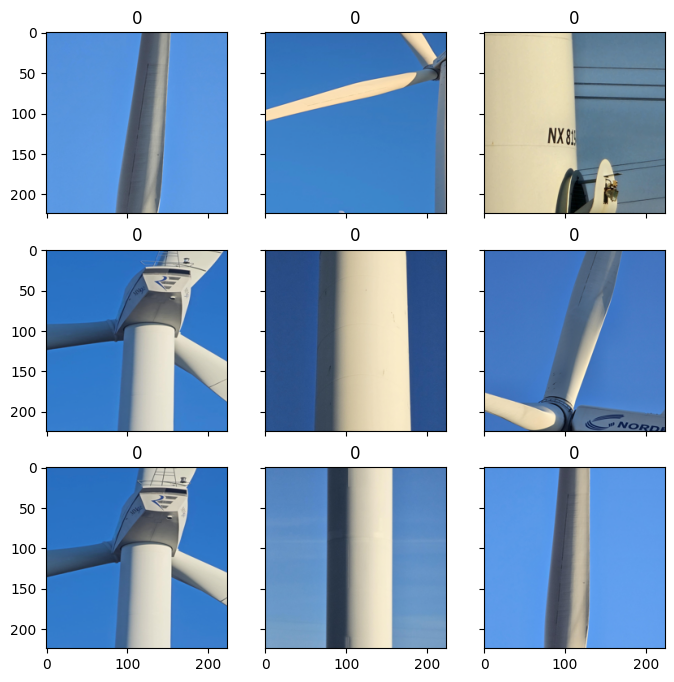

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,150))
    im_val, label = val_dataset[random_characters]

    file_name = extract_between_last_dots(train_val_files[random_characters].stem)
    box = []
    # if file_name in images_damages:
    #   box = images_damages[file_name]['box']

    # img_label = " ".join(map(lambda x: x.capitalize(),\
                # val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    img_label = str(label)
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x )

In [23]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [24]:
from torchvision import datasets, models, transforms


In [25]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    #Ваш код здесь
    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # установаить модель в режим обучения
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            curr_data = val_loader
            ln_d = len(val_loader)
            if phase == 'train':
              curr_data = train_loader
              ln_d = len(train_loader)

            # итерируемся по батчам
            for data in tqdm(curr_data, leave=False, desc=f"{phase} iter:"):
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                if train_on_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                if phase == "eval":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))


            epoch_loss = running_loss / ln_d
            epoch_acc = running_corrects / ln_d

            losses[phase].append(epoch_loss)

            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(
             #                       phase, epoch_loss, epoch_acc
              #                  ))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

In [43]:
import yaml
from tqdm import tqdm
import shutil
import os

# Создаем структуру папок
!mkdir -p yolo_dataset/train/images yolo_dataset/train/labels
!mkdir -p yolo_dataset/val/images yolo_dataset/val/labels
!mkdir -p yolo_dataset/test/images

# Создаем dataset.yaml

train_dest_img_path = '/kaggle/working/yolo_dataset/train/images'
train_dest_label_path = '/kaggle/working/yolo_dataset/train/labels'

val_dest_img_path = '/kaggle/working/yolo_dataset/val/images'
val_dest_label_path = '/kaggle/working/yolo_dataset/val/labels'

test_dest_img_path = '/kaggle/working/yolo_dataset/test/images'
test_dest_label_path = '/kaggle/working/yolo_dataset/test/labels'

data = {
    'train': '/kaggle/working/yolo_dataset/train',
    'val': '/kaggle/working/yolo_dataset/val',
    'test': '/kaggle/working/yolo_dataset/test',
    'names': ['no effect', 'corrosion', 'lightning', 'lightning receptor', 'missing teeth', 'patch'],
    'nc': 6
}


os.makedirs('/kaggle/working/yolo_dataset', exist_ok=True)

with open('/kaggle/working/yolo_dataset/dataset.yaml', 'w') as f:
    yaml.dump(data, f)

# Функция конвертации в YOLO формат
def convert_to_yolo_format(src_files, dest_img_dir, dest_label_dir,
                           test_mode = False):
    for file in tqdm(src_files):
        key = extract_between_last_dots(file.stem)
        
        # Копируем изображение
        dest_img = Path(dest_img_dir) / file.name
        shutil.copy(file, dest_img)
        
        # Создаем аннотацию
        txt_file = Path(dest_label_dir) / (dest_img.stem + '.txt')
        
        if key in images_damages:
            damage = images_damages[key]
            
            # Получаем размеры из словаря damages
            orig_width = damage['width']
            orig_height = damage['height']
            
            # Извлекаем и нормализуем координаты
            x, y, w, h = damage['box']
            x_center = (x + w/2) / orig_width
            y_center = (y + h/2) / orig_height
            width_n = w / orig_width
            height_n = h / orig_height
            
            with open(txt_file, 'w') as f:
                f.write(f"{damage['cat_id']} {x_center} {y_center} {width_n} {height_n}\n")
        else:
            if not test_mode:
                with open(txt_file, 'w') as f:
                    f.write("0 0.5 0.5 1.0 1.0\n")

# Конвертируем данные


convert_to_yolo_format(train_files, train_dest_img_path, train_dest_label_path)
convert_to_yolo_format(val_files, val_dest_img_path, val_dest_label_path)
convert_to_yolo_format(test_files, test_dest_img_path, test_dest_label_path,
                      True)

100%|██████████| 151/151 [00:00<00:00, 280.78it/s]


In [ ]:
pip install ultralytics

In [ ]:
from ultralytics import YOLO

# Инициализация модели
model = YOLO('yolov8n.pt').load('yolov8n.pt') #YOLO('yolov8n.pt')  # Предобученная модель

# Гиперпараметры
# Новые настройки обучения
# config = {
#     'data': 'yolo_dataset/dataset.yaml',
#     'epochs': 20,  # Уменьшаем количество эпох
#     'imgsz': 640,
#     'batch': 8,     # Уменьшаем batch size
#     'optimizer': 'AdamW',
#     'lr0': 0.0001,  # Уменьшаем learning rate
#     'patience': 10,
#     'device': 0,
#     'augment': True,  # Включаем аугментации
#     'dropout': 0.2,   # Регуляризация
#     'weight_decay': 0.0005,
#     'freeze': 10
# }

# config = {
#     'data': '/kaggle/working/yolo_dataset/dataset.yaml',
#     'epochs': 100,
#     'imgsz': 1280,
#     'batch': 4,  # Уменьшить batch size
#     'lr0': 0.01,
#     'lrf': 0.01,
#     'augment': True,
#     'mosaic': 0.5,
#     'mixup': 0.1,
#     'copy_paste': 0.1,
#     'fliplr': 0.5,
#     'degrees': 45,
#     'shear': 0.2,
#     'perspective': 0.0005,
#     'dropout': 0.2,
#     'weight_decay': 0.0005,
#     'device': 0
# }

config = {
    'data': '/kaggle/working/yolo_dataset/dataset.yaml',
    'epochs': 100,  # Увеличить количество эпох
    'imgsz': 1280,  # Увеличить разрешение (если позволяет память GPU)
    'batch': 4,     # Уменьшить batch size для больших изображений
    'lr0': 0.01,    # Повысить learning rate
    'lrf': 0.01,    # Конечный LR (cosine annealing)
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 3,
    'warmup_momentum': 0.8,
    'fliplr': 0.5,
    'mosaic': 1.0,  # Усилить аугментацию
    'mixup': 0.2,
    'copy_paste': 0.2,
    'degrees': 15,   # Уменьшить вращение
    'shear': 0.1,    # Уменьшить сдвиг
    'perspective': 0.0001,
    'hsv_h': 0.015,  # HSV аугментация
    'hsv_s': 0.7,
    'hsv_v': 0.4,
    'translate': 0.1,
    'scale': 0.5,
    'dropout': 0.1,  # Уменьшить dropout
    'device': 0
}

# Запуск обучения
results = model.train(**config)

# Валидация
metrics = model.val()
print(f"mAP@50-95: {metrics.box.map:.4f}")
print(f"mAP@50: {metrics.box.map50:.4f}")

Transferred 355/355 items from pretrained weights
Ultralytics 8.3.119 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/yolo_dataset/dataset.yaml, epochs=100, time=None, patience=100, batch=4, imgsz=1280, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train7, exist_ok=False, pretrained=yolov8n.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.1, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop

train: Scanning /kaggle/working/yolo_dataset/train/labels.cache... 1070 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1070/1070 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 404.2±147.6 MB/s, size: 806.6 KB)


val: Scanning /kaggle/working/yolo_dataset/val/labels.cache... 271 images, 0 backgrounds, 0 corrupt: 100%|██████████| 271/271 [00:00<?, ?it/s]


Plotting labels to runs/detect/train7/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 4 dataloader workers
Logging results to runs/detect/train7
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.12G      2.591      12.09      2.665          8       1280: 100%|██████████| 268/268 [01:21<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:08<00:00,  3.93it/s]

                   all        271        271      0.418       0.31      0.226     0.0576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.57G      2.297      8.283       2.26          2       1280: 100%|██████████| 268/268 [01:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:08<00:00,  4.05it/s]


                   all        271        271      0.345      0.461      0.265      0.068

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.57G      2.081      5.579      2.183          4       1280: 100%|██████████| 268/268 [01:18<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.56it/s]

                   all        271        271      0.345      0.424      0.331       0.09



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.57G      2.009      4.668      2.081          3       1280: 100%|██████████| 268/268 [01:20<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.65it/s]

                   all        271        271      0.332      0.561      0.337     0.0962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.57G      1.925       3.73      2.058          9       1280: 100%|██████████| 268/268 [01:17<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:06<00:00,  4.87it/s]

                   all        271        271      0.264      0.559      0.317      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.57G       1.84      3.179      1.982          5       1280: 100%|██████████| 268/268 [01:18<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.53it/s]

                   all        271        271      0.388      0.369      0.364      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.57G      1.813      3.083      1.949          9       1280: 100%|██████████| 268/268 [01:17<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.55it/s]

                   all        271        271      0.334       0.45      0.392      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.57G      1.821      2.878      1.932          6       1280: 100%|██████████| 268/268 [01:21<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.56it/s]

                   all        271        271      0.316      0.472      0.333      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.57G       1.76       2.62      1.897          6       1280: 100%|██████████| 268/268 [01:18<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.54it/s]

                   all        271        271      0.348      0.395      0.371      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.57G      1.744      2.473      1.849          1       1280: 100%|██████████| 268/268 [01:15<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:08<00:00,  4.22it/s]


                   all        271        271      0.331      0.506       0.37      0.123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.57G      1.658      2.256      1.835          5       1280: 100%|██████████| 268/268 [01:16<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.57it/s]


                   all        271        271      0.478      0.402       0.41      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.57G       1.66      2.291      1.837          3       1280: 100%|██████████| 268/268 [01:21<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:06<00:00,  4.87it/s]

                   all        271        271      0.341      0.605      0.391      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.57G      1.625      2.198      1.807          2       1280: 100%|██████████| 268/268 [01:18<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.31it/s]

                   all        271        271      0.379      0.343      0.319     0.0908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.57G      1.635      2.094       1.74          8       1280: 100%|██████████| 268/268 [01:18<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.46it/s]


                   all        271        271      0.363      0.613      0.426      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.57G      1.653      2.128       1.75          2       1280: 100%|██████████| 268/268 [01:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:06<00:00,  4.94it/s]

                   all        271        271      0.381       0.48      0.369      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.57G      1.561      1.994       1.69          2       1280: 100%|██████████| 268/268 [01:15<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.28it/s]


                   all        271        271      0.414      0.624      0.468      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.57G       1.54      1.987      1.682          3       1280: 100%|██████████| 268/268 [01:16<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.46it/s]


                   all        271        271      0.326      0.616      0.396      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.57G      1.628      2.136       1.69          2       1280: 100%|██████████| 268/268 [01:18<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.84it/s]

                   all        271        271      0.339       0.59      0.417      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.57G      1.566      2.073      1.694          5       1280: 100%|██████████| 268/268 [01:19<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.42it/s]

                   all        271        271      0.402      0.635      0.508      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.57G      1.518      2.033      1.662          3       1280: 100%|██████████| 268/268 [01:15<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:06<00:00,  4.92it/s]


                   all        271        271      0.354      0.616      0.408      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.57G      1.559      2.014      1.657          6       1280: 100%|██████████| 268/268 [01:20<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.81it/s]

                   all        271        271      0.391      0.427      0.404      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.57G      1.511      1.902      1.685          5       1280: 100%|██████████| 268/268 [01:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.61it/s]

                   all        271        271      0.412       0.63      0.511      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.57G      1.483      1.898       1.62          4       1280: 100%|██████████| 268/268 [01:16<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:06<00:00,  4.88it/s]

                   all        271        271       0.42      0.694      0.464      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.57G      1.515      1.984      1.577         10       1280:  33%|███▎      | 89/268 [00:25<00:44,  4.07it/s]

In [64]:
# # Предсказание на тестовых данных
# test_results = model.predict('/kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test', save=True, conf=0.25)

# # Визуализация результатов
# for result in test_results:
#     result.show()

# # Экспорт модели в ONNX
# model.export(format='onnx')

In [111]:
82 * 100  / 60 /60

2.2777777777777777

In [46]:
# from pycocotools.coco import COCO
# from pycocotools.cocoeval import COCOeval

# # Конвертация результатов в COCO формат
# coco_results = []
# for result in test_results:
#     image_id = Path(result.path).stem
#     boxes = result.boxes.xywhn.cpu().numpy()
#     scores = result.boxes.conf.cpu().numpy()
#     labels = result.boxes.cls.cpu().numpy().astype(int)
    
#     for box, score, label in zip(boxes, scores, labels):
#         coco_results.append({
#             'image_id': image_id,
#             'category_id': int(label),
#             'bbox': [float(box[0]), float(box[1]), float(box[2]), float(box[3])],
#             'score': float(score)
#         })

# # Сохранение и оценка
# # os.makedirs('/content/Wind Turbine damage/train/labels', exist_ok=True)

# with open('/kaggle/working/yolo_dataset/coco_predictions.json', 'w') as f:
#     json.dump(coco_results, f)

# coco_gt = COCO('/kaggle/input/adadaaf/_annotations.coco.json') #COCO('/kaggle/working/yolo_dataset/annotations.json')
# coco_dt = coco_gt.loadRes('/kaggle/working/yolo_dataset/coco_predictions.json')

# coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
# coco_eval.evaluate()
# coco_eval.accumulate()
# coco_eval.summarize()

In [90]:
model_predict = '/kaggle/working/yolo11n.pt'
model_predict = YOLO('/kaggle/working/runs/detect/train7/weights/best.pt')  # Полный путь к файлу


In [108]:
import csv
from pathlib import Path
from ultralytics import YOLO
import torch

import cv2

def get_image_size(image_path):
    img = cv2.imread(str(image_path))
    height, width = img.shape[:2]
    return width, height  # (width, height)

# Загрузка обученной модели
# model = YOLO('best.pt')  # Укажите путь к вашей обученной модели

# Словарь для преобразования ID классов в имена
class_names = {
    0:'no effect',
    1: 'corrosion',
    2: 'lightning',
    3: 'lightning receptor',
    4: 'missing teeth',
    5: 'patch'
}

# Функция для преобразования YOLO формата в требуемый
def format_prediction(box, class_id, conf, orig_width, orig_height):
    x_center = box[0].item() * orig_width
    y_center = box[1].item() * orig_height
    width = box[2].item() * orig_width
    height = box[3].item() * orig_height

    # Вычисляем координаты левого верхнего угла
    x1 = x_center - (width / 2)
    y1 = y_center - (height / 2)
    
    return [
        class_names[class_id],
        round(x1, 2),
        round(y1, 2),
        round(width, 2),
        round(height, 2),
        round(conf.item(), 5)
    ]

# Генерация предсказаний
def generate_predictions(test_dir, prediction_params):
    results = []
    
    # # Новые параметры предсказания
    # prediction_params = {
    #     'conf': 0.01,      # Оставить низкий порог
    #     'iou': 0.45,        # Более строгий NMS
    #     'agnostic_nms': False,
    #     'augment': True,    # TTA
    #     'half': True,       # Использовать половинную точность
    #     'max_det': 300      # Увеличить лимит детекций
    # }
    
    for img_path in tqdm(sorted(Path(test_dir).rglob('*.jpg'))):
        orig_width, orig_height = get_image_size(img_path)
        
        # Предсказание с новыми параметрами
        prediction = model_predict.predict(img_path, **prediction_params)
        
        # Обработка результатов
        boxes = prediction[0].boxes.xywhn
        classes = prediction[0].boxes.cls
        confs = prediction[0].boxes.conf
        
        # Фильтрация слишком больших боксов
        filtered = []
        for box, class_id, conf in zip(boxes, classes, confs):
            w = box[2].item() * orig_width
            h = box[3].item() * orig_height
            
            # Фильтр по размеру (настройте под ваши данные)
            # if 20 < w < orig_width*0.8 and 20 < h < orig_height*0.8:
            filtered.append((box, class_id, conf))
        
        # Форматирование
        formatted = [
            format_prediction(b, int(cid), cf, orig_width, orig_height)
            for b, cid, cf in filtered
        ]
        
        results.append({
            'image_id': img_path.name,
            'objects': formatted
        })
    
    return results

# Генерируем предсказания
test_dir = '/kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test'
# predictions = generate_predictions(test_dir)

best_params = {
    'conf': 0.001,       # Низкий порог (v1)
    'iou': 0.2,          # Мягкий NMS (v1)
    'augment': True,     # TTA (v1, v4)
    'half': True         # FP16 (v4)
}

param_combinations  = [
    # Вариант 7: Увеличенный лимит детекций
    # {**best_params, 'max_det': 500},
    
    # Вариант 8: Строгий NMS с TTA
    # {'conf': 0.001, 'iou': 0.5, 'augment': True, 'half': True},
        
    # Вариант 10: Ансамблирование (требует 2+ моделей)
    # {'conf': 0.005, 'iou': 0.4, 'augment': True},

    # Ultra-low confidence
    {'conf': 0.0005, 'iou': 0.2, 'augment': True, 'half': True, 'max_det': 300},
    
    # Balanced params
    {'conf': 0.001, 'iou': 0.25, 'augment': True, 'half': False, 'max_det': 200},
    
    
    # Size filtering
    {'conf': 0.001, 'iou': 0.2, 'augment': True},
    
    # Hybrid approach
    {'conf': [0.001, 0.01], 'iou': [0.2, 0.4], 'augment': True}  # Мульти-порог
]

for i, params in enumerate(param_combinations, 1):
    print(f"\nГенерация предсказаний с параметрами {params}")
    
    # Добавляем обязательные параметры
    full_params = {
        'agnostic_nms': False,
        **params
    }
    
    predictions = generate_predictions(test_dir, full_params)
    
    # Формируем DataFrame
    images = []
    objects = []
    
    for pred in predictions:
        objects_str = str([[obj[0]] + obj[1:] for obj in pred['objects']]).replace("'", '"')
        objects.append(objects_str)
        images.append(pred['image_id'])
    
    preds = pd.DataFrame({'image_id': images, 'objects': objects})
    
    # Сохраняем файл
    filename = f'submission_v{i}.csv'
    preds.to_csv(filename, index=False)
    print(f"Файл {filename} успешно сохранен")
    
    # Для удобства сохраняем и параметры
    with open(f'params_v{i}.txt', 'w') as f:
        f.write(str(params))




Генерация предсказаний с параметрами {'conf': 0.0005, 'iou': 0.2, 'augment': True, 'half': True, 'max_det': 300}


  0%|          | 0/151 [00:00<?, ?it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_150729_jpg.rf.5925f54483de8cc52f75fdd1dc0ec3a0.jpg: 1280x1280 1 no effect, 4 corrosions, 2 missing teeths, 31.3ms
Speed: 12.8ms preprocess, 31.3ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 1280)


  1%|          | 1/151 [00:00<00:20,  7.31it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_153628_jpg.rf.67030e3c4592587d26d7762e8e091020.jpg: 1280x1280 1 no effect, 13 corrosions, 4 missing teeths, 31.7ms
Speed: 14.3ms preprocess, 31.7ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


  1%|▏         | 2/151 [00:00<00:54,  2.72it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_153658_jpg.rf.66dc04dc4ee8194ccc19397d4ad42f2e.jpg: 1280x1280 3 no effects, 1 corrosion, 31.7ms
Speed: 14.1ms preprocess, 31.7ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


  2%|▏         | 3/151 [00:01<01:03,  2.34it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_153711_jpg.rf.3a50aa9daa881abe4296c7f12b03fcf9.jpg: 1280x1280 2 no effects, 15 corrosions, 20 missing teeths, 31.3ms
Speed: 13.9ms preprocess, 31.3ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


  3%|▎         | 4/151 [00:01<01:07,  2.17it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_153748-0-_jpg.rf.6c50a8089bf3ccd32bb61e347e9f4019.jpg: 1280x1280 2 no effects, 5 corrosions, 31.2ms
Speed: 13.6ms preprocess, 31.2ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)


  3%|▎         | 5/151 [00:02<01:10,  2.07it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_153754_jpg.rf.01e099db13ef7c0beee133daa6379466.jpg: 1280x1280 1 no effect, 4 corrosions, 1 missing teeth, 1 patch, 31.7ms
Speed: 13.7ms preprocess, 31.7ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


  4%|▍         | 6/151 [00:02<01:12,  1.99it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_153843-0-_jpg.rf.60b55d7dd594d0869bf7216a34d16385.jpg: 1280x1280 2 no effects, 20 corrosions, 4 missing teeths, 1 patch, 32.6ms
Speed: 13.4ms preprocess, 32.6ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)


  5%|▍         | 7/151 [00:02<00:54,  2.65it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_153843_jpg.rf.b24d413669fa575889018912a2b372e9.jpg: 1280x1280 3 no effects, 14 corrosions, 1 lightning, 3 missing teeths, 4 patchs, 31.8ms
Speed: 13.1ms preprocess, 31.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


  5%|▌         | 8/151 [00:02<00:42,  3.37it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0000_jpg.rf.66e7e87b86904e97508657a58ba9972c.jpg: 1280x736 1 no effect, 7 corrosions, 1 missing teeth, 25.4ms
Speed: 7.0ms preprocess, 25.4ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0015_jpg.rf.62ada8738a17b071f5859ef2ba587652.jpg: 1280x736 1 no effect, 2 corrosions, 25.7ms
Speed: 6.8ms preprocess, 25.7ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


  7%|▋         | 10/151 [00:03<00:25,  5.46it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0034_jpg.rf.32c6d4c6f0fe3e919f7db3fea5d74dca.jpg: 1280x736 1 no effect, 3 corrosions, 1 patch, 26.3ms
Speed: 6.4ms preprocess, 26.3ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0061_jpg.rf.ea7113440055cbce048892f47f14cd42.jpg: 1280x736 1 no effect, 4 corrosions, 1 missing teeth, 26.8ms
Speed: 6.6ms preprocess, 26.8ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 736)


  8%|▊         | 12/151 [00:03<00:18,  7.56it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0075_jpg.rf.82235fee115b78aac2460ceb4f6758a0.jpg: 1280x736 1 no effect, 9 corrosions, 1 missing teeth, 1 patch, 26.0ms
Speed: 6.7ms preprocess, 26.0ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0077_jpg.rf.17e71709fd53ea08911fdec60dd0f3df.jpg: 1280x736 1 no effect, 2 corrosions, 26.8ms
Speed: 6.5ms preprocess, 26.8ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 736)


  9%|▉         | 14/151 [00:03<00:14,  9.59it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0079_jpg.rf.ed1b222a0cf341a04f27bcdc26a65687.jpg: 1280x736 1 no effect, 2 corrosions, 1 patch, 26.3ms
Speed: 6.7ms preprocess, 26.3ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0081_jpg.rf.47e59973cbd4e1f40363bf218c380254.jpg: 1280x736 1 no effect, 3 corrosions, 26.4ms
Speed: 6.8ms preprocess, 26.4ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 11%|█         | 16/151 [00:03<00:11, 11.29it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0084_jpg.rf.de984895faf812264c6c6a416eb62e02.jpg: 1280x736 1 no effect, 1 corrosion, 1 missing teeth, 25.6ms
Speed: 6.7ms preprocess, 25.6ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0086_jpg.rf.1d43d0c9b738b921d5601116df4d1965.jpg: 1280x736 1 no effect, 2 corrosions, 28.1ms
Speed: 7.0ms preprocess, 28.1ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 12%|█▏        | 18/151 [00:03<00:10, 12.80it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0088_jpg.rf.ef0c44646fd1469ebacc82989015336b.jpg: 1280x736 1 no effect, 4 corrosions, 26.0ms
Speed: 6.6ms preprocess, 26.0ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0095_jpg.rf.40c05c5950a48627a9add8cb56d60ca9.jpg: 1280x736 1 no effect, 2 corrosions, 26.2ms
Speed: 6.8ms preprocess, 26.2ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 13%|█▎        | 20/151 [00:03<00:09, 13.63it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0110_jpg.rf.a5ed327b0bb16f8bc19802aab18f92f0.jpg: 1280x736 1 no effect, 1 corrosion, 26.6ms
Speed: 6.9ms preprocess, 26.6ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0126_jpg.rf.5a9e67fd5bce7969a5775f6ff5273805.jpg: 1280x736 1 no effect, 1 corrosion, 28.0ms
Speed: 6.8ms preprocess, 28.0ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 15%|█▍        | 22/151 [00:03<00:08, 14.69it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0134_jpg.rf.5aa81e12178bd71422c009b29fde0726.jpg: 1280x736 1 no effect, 1 corrosion, 28.6ms
Speed: 6.6ms preprocess, 28.6ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0149_jpg.rf.45490f1c8ade5580d1279140588b187b.jpg: 1280x736 1 no effect, 3 corrosions, 1 missing teeth, 26.3ms
Speed: 6.8ms preprocess, 26.3ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 736)


 16%|█▌        | 24/151 [00:03<00:08, 15.39it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0155_jpg.rf.2ae5c8fbaa05347ec7fd8a91a06defe3.jpg: 1280x736 1 no effect, 1 corrosion, 1 missing teeth, 26.2ms
Speed: 6.7ms preprocess, 26.2ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0160_jpg.rf.94f5e7408084ab5c0e36cec28179010d.jpg: 1280x736 1 no effect, 4 corrosions, 26.2ms
Speed: 6.6ms preprocess, 26.2ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 736)


 17%|█▋        | 26/151 [00:04<00:07, 16.09it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0162_jpg.rf.8b7f8d55232f8cb9ddf65739df72e6a7.jpg: 1280x736 1 no effect, 3 corrosions, 1 missing teeth, 26.4ms
Speed: 6.5ms preprocess, 26.4ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0169_jpg.rf.5e1be9ba9931db503f8f947f84fe617c.jpg: 1280x736 1 no effect, 8 corrosions, 1 missing teeth, 26.2ms
Speed: 6.4ms preprocess, 26.2ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 736)


 19%|█▊        | 28/151 [00:04<00:07, 16.70it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0181_jpg.rf.66646f9753d87d16a241d1a3e292f0b6.jpg: 1280x736 1 no effect, 2 corrosions, 2 patchs, 27.1ms
Speed: 6.6ms preprocess, 27.1ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0191_jpg.rf.f484f72de307f2e534029f265407a11a.jpg: 1280x736 1 no effect, 1 corrosion, 26.0ms
Speed: 6.7ms preprocess, 26.0ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 736)


 20%|█▉        | 30/151 [00:04<00:07, 17.02it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0194_jpg.rf.d159889f8505128041a06c158de5722c.jpg: 1280x736 1 no effect, 2 corrosions, 26.1ms
Speed: 6.7ms preprocess, 26.1ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0197_jpg.rf.441cee5d1329381499818d23066115d8.jpg: 1280x736 1 no effect, 3 corrosions, 26.1ms
Speed: 6.4ms preprocess, 26.1ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 736)


 21%|██        | 32/151 [00:04<00:06, 17.26it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0202_jpg.rf.635e5d1d6357a368cd07285e3859f2f4.jpg: 1280x736 1 no effect, 4 corrosions, 25.7ms
Speed: 6.3ms preprocess, 25.7ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0214_jpg.rf.3c67777e183c90e06f84a4c5b9115c0d.jpg: 1280x736 1 no effect, 2 corrosions, 27.0ms
Speed: 6.4ms preprocess, 27.0ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 736)


 23%|██▎       | 34/151 [00:04<00:06, 17.23it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0222_jpg.rf.10d6752c3fb32b117287db9cb9ba6e0b.jpg: 1280x736 1 no effect, 3 corrosions, 1 patch, 25.8ms
Speed: 6.4ms preprocess, 25.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_160457-0-_jpg.rf.609b8e725f177836e00fd543f6d92f73.jpg: 1280x1280 2 no effects, 168 corrosions, 31 missing teeths, 1 patch, 30.1ms
Speed: 12.9ms preprocess, 30.1ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 24%|██▍       | 36/151 [00:04<00:08, 13.03it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_160553_jpg.rf.02cafabaceab373ddc1e5c30e1ba8499.jpg: 1280x1280 3 no effects, 213 corrosions, 2 lightnings, 41 missing teeths, 29.9ms
Speed: 12.8ms preprocess, 29.9ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 1280)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_160557_jpg.rf.4d9909256e4bcb526d3eb1b63082b093.jpg: 1280x1280 1 no effect, 122 corrosions, 1 lightning, 17 missing teeths, 2 patchs, 30.4ms
Speed: 12.9ms preprocess, 30.4ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 25%|██▌       | 38/151 [00:04<00:10, 10.39it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_160706-0-_jpg.rf.8582ddb4316cf299a51bcb10f58e36a5.jpg: 1280x1280 2 no effects, 31 corrosions, 2 missing teeths, 30.0ms
Speed: 12.6ms preprocess, 30.0ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_160706_jpg.rf.6b2e2b4a13dc2e6d5946abcebccaa874.jpg: 1280x1280 1 no effect, 47 corrosions, 11 missing teeths, 37.5ms
Speed: 15.7ms preprocess, 37.5ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 1280)


 26%|██▋       | 40/151 [00:05<00:12,  9.18it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_160957_jpg.rf.5155c81578046677bece204ddb26c09d.jpg: 1280x1280 4 no effects, 16 corrosions, 3 missing teeths, 30.1ms
Speed: 13.0ms preprocess, 30.1ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161014_jpg.rf.a886dd45473612fae63ab4fed235c9de.jpg: 1280x1280 4 no effects, 16 corrosions, 2 missing teeths, 30.4ms
Speed: 12.7ms preprocess, 30.4ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 28%|██▊       | 42/151 [00:05<00:12,  8.62it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161017_jpg.rf.951c430467f8f672bd6885680ab7dadc.jpg: 1280x1280 1 no effect, 1 corrosion, 2 missing teeths, 30.4ms
Speed: 14.3ms preprocess, 30.4ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 28%|██▊       | 43/151 [00:05<00:12,  8.38it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161023_jpg.rf.1af5fe6c0ba91aacdc8502f9365d62dc.jpg: 1280x1280 2 no effects, 72 corrosions, 4 missing teeths, 1 patch, 30.0ms
Speed: 12.9ms preprocess, 30.0ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 29%|██▉       | 44/151 [00:05<00:13,  7.86it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161103-0-_jpg.rf.7ac8bc94eb0190afc02b4a4ceab49ac1.jpg: 1280x1280 3 no effects, 73 corrosions, 14 missing teeths, 1 patch, 29.7ms
Speed: 13.4ms preprocess, 29.7ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 30%|██▉       | 45/151 [00:05<00:13,  7.85it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161118_jpg.rf.c474047ad5d392415971b82ea2691ff5.jpg: 1280x1280 1 no effect, 6 corrosions, 1 missing teeth, 32.0ms
Speed: 13.1ms preprocess, 32.0ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 30%|███       | 46/151 [00:06<00:13,  7.61it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161126_jpg.rf.af941467cefb044aa50ac875b6bdc0e8.jpg: 1280x1280 3 no effects, 62 corrosions, 6 missing teeths, 32.2ms
Speed: 13.1ms preprocess, 32.2ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 31%|███       | 47/151 [00:06<00:14,  7.15it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161133-0-_jpg.rf.dcddf116ed0ce393efa094713138319c.jpg: 1280x1280 2 no effects, 3 corrosions, 18 missing teeths, 31.9ms
Speed: 12.7ms preprocess, 31.9ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 32%|███▏      | 48/151 [00:06<00:14,  7.23it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161134-0-_jpg.rf.bdb581aa01a6efc955bd97285dbd74e1.jpg: 1280x1280 2 no effects, 1 corrosion, 31.8ms
Speed: 12.8ms preprocess, 31.8ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 32%|███▏      | 49/151 [00:06<00:13,  7.37it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161207_jpg.rf.b811af46b8e7c338c1ffaabeb5cf66bb.jpg: 1280x1280 3 no effects, 2 corrosions, 32.3ms
Speed: 13.2ms preprocess, 32.3ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 33%|███▎      | 50/151 [00:06<00:12,  7.78it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161228_jpg.rf.8551f713d2a16451aa3ba4c2b155e00b.jpg: 1280x1280 1 no effect, 3 corrosions, 59 missing teeths, 33.4ms
Speed: 12.8ms preprocess, 33.4ms inference, 2.2ms postprocess per image at shape (1, 3, 1280, 1280)


 34%|███▍      | 51/151 [00:06<00:13,  7.47it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162824_jpg.rf.a51b12875976d0bffc12c06581c56936.jpg: 1280x1280 1 no effect, 1 corrosion, 53 missing teeths, 31.7ms
Speed: 12.6ms preprocess, 31.7ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 1280)


 34%|███▍      | 52/151 [00:06<00:13,  7.45it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162828-1-_jpg.rf.4fdac321731d4d3db13d4b820258854b.jpg: 1280x1280 1 no effect, 4 corrosions, 1 missing teeth, 31.7ms
Speed: 12.9ms preprocess, 31.7ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 35%|███▌      | 53/151 [00:07<00:12,  7.57it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162838_jpg.rf.306512a3b2d96f18f9dea28941d46350.jpg: 1280x1280 2 no effects, 7 corrosions, 5 missing teeths, 31.7ms
Speed: 13.0ms preprocess, 31.7ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 36%|███▌      | 54/151 [00:07<00:12,  7.63it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162844-0-_jpg.rf.9b6edc74a2607728b200221a9fdc546b.jpg: 1280x1280 1 no effect, 13 corrosions, 49 missing teeths, 31.9ms
Speed: 12.7ms preprocess, 31.9ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 36%|███▋      | 55/151 [00:07<00:13,  7.38it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162844-1-_jpg.rf.c25211b4ab0af41936afc89d5946f32b.jpg: 1280x1280 1 no effect, 14 corrosions, 15 missing teeths, 31.7ms
Speed: 12.9ms preprocess, 31.7ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 37%|███▋      | 56/151 [00:07<00:13,  7.27it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162851-0-_jpg.rf.5becbe16d62094a5106285708a1ec473.jpg: 1280x1280 1 no effect, 7 corrosions, 48 missing teeths, 1 patch, 31.9ms
Speed: 13.0ms preprocess, 31.9ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 38%|███▊      | 57/151 [00:07<00:12,  7.25it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162905-0-_jpg.rf.cec91a04d4d97418ef532934b05aa31d.jpg: 1280x1280 1 no effect, 2 corrosions, 39 missing teeths, 32.0ms
Speed: 12.5ms preprocess, 32.0ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 38%|███▊      | 58/151 [00:07<00:12,  7.31it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162912-0-_jpg.rf.3d1a61f602d2413278b9f6cb2f8f111f.jpg: 1280x1280 1 no effect, 18 corrosions, 12 missing teeths, 32.1ms
Speed: 12.9ms preprocess, 32.1ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 39%|███▉      | 59/151 [00:07<00:12,  7.29it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162914-0-_jpg.rf.f59673051fd81362e6b0d7794bab432b.jpg: 1280x1280 2 no effects, 3 corrosions, 38 missing teeths, 32.1ms
Speed: 13.1ms preprocess, 32.1ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 40%|███▉      | 60/151 [00:08<00:12,  7.38it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162955-0-_jpg.rf.1495715f852a7fff8456e044dd26cc11.jpg: 1280x1280 2 no effects, 2 corrosions, 52 missing teeths, 32.9ms
Speed: 13.1ms preprocess, 32.9ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 40%|████      | 61/151 [00:08<00:12,  7.32it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163003-1-_jpg.rf.e256f36bd594cafc2041415d9a119600.jpg: 1280x1280 3 no effects, 2 corrosions, 31.8ms
Speed: 12.6ms preprocess, 31.8ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 41%|████      | 62/151 [00:08<00:11,  7.47it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163005-0-_jpg.rf.ab8c91946df2390ab574f5de89fba09e.jpg: 1280x1280 2 no effects, 5 corrosions, 1 missing teeth, 31.8ms
Speed: 13.2ms preprocess, 31.8ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)


 42%|████▏     | 63/151 [00:08<00:11,  7.60it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163020-0-_jpg.rf.e503792ced04bce579305e19fa3a485c.jpg: 1280x1280 2 no effects, 20 corrosions, 21 missing teeths, 31.9ms
Speed: 13.1ms preprocess, 31.9ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 42%|████▏     | 64/151 [00:08<00:11,  7.48it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163021-0-_jpg.rf.2b48f3937dc7bd85cc5b2570c331b0fe.jpg: 1280x1280 1 no effect, 22 corrosions, 39 missing teeths, 31.9ms
Speed: 13.1ms preprocess, 31.9ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 43%|████▎     | 65/151 [00:08<00:11,  7.33it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163033-0-_jpg.rf.baf4645828be43c72d9e8fcfc24b64b5.jpg: 1280x1280 1 no effect, 19 corrosions, 73 missing teeths, 31.5ms
Speed: 13.3ms preprocess, 31.5ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 44%|████▎     | 66/151 [00:08<00:11,  7.21it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163038_jpg.rf.dc1643fa88e3f647d7664ce37a39f3fe.jpg: 1280x1280 1 no effect, 19 corrosions, 79 missing teeths, 31.4ms
Speed: 13.2ms preprocess, 31.4ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 44%|████▍     | 67/151 [00:08<00:11,  7.11it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163040-0-_jpg.rf.9a6a8c19c726628a53bd9f5db3f2f439.jpg: 1280x1280 1 no effect, 20 corrosions, 75 missing teeths, 31.7ms
Speed: 13.1ms preprocess, 31.7ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 45%|████▌     | 68/151 [00:09<00:11,  7.02it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163044_jpg.rf.9d8b6fcd8b4cbab86c02647c41f007d5.jpg: 1280x1280 2 no effects, 21 corrosions, 44 missing teeths, 2 patchs, 31.3ms
Speed: 13.2ms preprocess, 31.3ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 46%|████▌     | 69/151 [00:09<00:11,  7.02it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163045-0-_jpg.rf.ee9cb8ff7b1709019cea1ed609b67d2f.jpg: 1280x1280 1 no effect, 24 corrosions, 32 missing teeths, 1 patch, 31.9ms
Speed: 12.7ms preprocess, 31.9ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)


 46%|████▋     | 70/151 [00:09<00:11,  7.03it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163052_jpg.rf.111fcd1bad265aa0c2447269bca9a49a.jpg: 1280x1280 1 no effect, 4 corrosions, 51 missing teeths, 31.6ms
Speed: 13.0ms preprocess, 31.6ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 47%|████▋     | 71/151 [00:09<00:11,  7.16it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163053-1-_jpg.rf.d5e4b0912ebe72247db35232ba3fffdd.jpg: 1280x1280 2 no effects, 4 corrosions, 57 missing teeths, 31.4ms
Speed: 13.1ms preprocess, 31.4ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 48%|████▊     | 72/151 [00:09<00:10,  7.26it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163054_jpg.rf.9456e409d5d472605b41e51c47f80d04.jpg: 1280x1280 1 no effect, 2 corrosions, 54 missing teeths, 31.9ms
Speed: 13.0ms preprocess, 31.9ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)


 48%|████▊     | 73/151 [00:09<00:10,  7.34it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163623_jpg.rf.dadee9dfb41e95b4016dd97010437f84.jpg: 1280x1280 1 no effect, 29 corrosions, 10 missing teeths, 31.2ms
Speed: 13.3ms preprocess, 31.2ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 49%|████▉     | 74/151 [00:09<00:10,  7.26it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163626_jpg.rf.bb15a2c995255433bb8e8aabcd91c8b5.jpg: 1280x1280 1 no effect, 34 corrosions, 11 missing teeths, 31.2ms
Speed: 13.1ms preprocess, 31.2ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 50%|████▉     | 75/151 [00:10<00:10,  7.18it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163642_jpg.rf.a184fefcd0f1c68991113d7b4d82cf0c.jpg: 1280x1280 1 no effect, 2 corrosions, 60 missing teeths, 31.4ms
Speed: 13.1ms preprocess, 31.4ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 50%|█████     | 76/151 [00:10<00:10,  7.17it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163644-0-_jpg.rf.968f7d72ae7be6ef8733b42490c03aed.jpg: 1280x1280 1 no effect, 5 corrosions, 85 missing teeths, 31.6ms
Speed: 13.7ms preprocess, 31.6ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)


 51%|█████     | 77/151 [00:10<00:10,  7.10it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163650-0-_jpg.rf.6ff26d6832686600c6f18b4be821482e.jpg: 1280x1280 1 no effect, 6 corrosions, 57 missing teeths, 1 patch, 31.3ms
Speed: 12.9ms preprocess, 31.3ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 52%|█████▏    | 78/151 [00:10<00:10,  7.13it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163650_jpg.rf.d420c98f550cdddfdcf15388a6232091.jpg: 1280x1280 1 no effect, 5 corrosions, 58 missing teeths, 1 patch, 31.4ms
Speed: 12.9ms preprocess, 31.4ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 52%|█████▏    | 79/151 [00:10<00:10,  7.07it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163730-0-_jpg.rf.7139d077e629ae78b03081e5ca84dd98.jpg: 1280x1280 2 no effects, 28 corrosions, 24 missing teeths, 31.4ms
Speed: 13.3ms preprocess, 31.4ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 53%|█████▎    | 80/151 [00:10<00:09,  7.12it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164156_jpg.rf.271c749cefc88f123dd383e89b32dfed.jpg: 1280x1280 6 no effects, 18 corrosions, 9 missing teeths, 32.0ms
Speed: 13.2ms preprocess, 32.0ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 54%|█████▎    | 81/151 [00:10<00:09,  7.30it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-2330_jpg.rf.99f885a1881dee8e72b0e2cc91350290.jpg: 1280x736 1 no effect, 3 corrosions, 13 missing teeths, 25.7ms
Speed: 6.6ms preprocess, 25.7ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-2500_jpg.rf.f8151151ee2c00ac3ff469cadc42e2dc.jpg: 1280x736 1 no effect, 13 corrosions, 1 lightning, 25.7ms
Speed: 6.7ms preprocess, 25.7ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 736)


 55%|█████▍    | 83/151 [00:11<00:06,  9.87it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4110_jpg.rf.bc5bdabb1f57eb50d3bd4098c921d1fd.jpg: 1280x736 1 no effect, 4 corrosions, 25.6ms
Speed: 6.8ms preprocess, 25.6ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4114_jpg.rf.5fa408a4c5bfd3b186f2a54dc555e753.jpg: 1280x736 1 no effect, 3 corrosions, 1 patch, 26.5ms
Speed: 6.5ms preprocess, 26.5ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 736)


 56%|█████▋    | 85/151 [00:11<00:05, 12.06it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4148_jpg.rf.816f4ef4d1de664e9f6fcc45f6dfa11f.jpg: 1280x736 2 no effects, 5 corrosions, 1 lightning, 26.1ms
Speed: 6.5ms preprocess, 26.1ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4186_jpg.rf.acc31c48a0599af4ab5b90bf6b4a6136.jpg: 1280x736 2 no effects, 11 corrosions, 5 missing teeths, 25.1ms
Speed: 6.5ms preprocess, 25.1ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 736)


 58%|█████▊    | 87/151 [00:11<00:04, 13.66it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4190_jpg.rf.35c7cf908606d69f9e88e50415690b7f.jpg: 1280x736 2 no effects, 12 corrosions, 5 missing teeths, 25.9ms
Speed: 6.8ms preprocess, 25.9ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4714_jpg.rf.ab56dbe039b90c154f6ebacce19869f1.jpg: 1280x736 1 no effect, 26.6ms
Speed: 6.6ms preprocess, 26.6ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 59%|█████▉    | 89/151 [00:11<00:04, 14.89it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4724_jpg.rf.db7990b2d0a32e3af5930cb8d63704b6.jpg: 1280x736 1 no effect, 25.6ms
Speed: 6.8ms preprocess, 25.6ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4758_jpg.rf.7ec5f576a67700199ac4c7e897253413.jpg: 1280x736 1 no effect, 25.6ms
Speed: 6.4ms preprocess, 25.6ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 736)


 60%|██████    | 91/151 [00:11<00:03, 16.08it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4881_jpg.rf.4682e343f5944b5f911d891965f0b6d8.jpg: 1280x736 1 no effect, 6 corrosions, 25.8ms
Speed: 6.4ms preprocess, 25.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4909_jpg.rf.c2880db9ff2ebe752daa97bc61d1b947.jpg: 1280x736 1 no effect, 7 corrosions, 1 missing teeth, 26.0ms
Speed: 6.6ms preprocess, 26.0ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 736)


 62%|██████▏   | 93/151 [00:11<00:03, 16.63it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0685-1-_JPG.rf.28e5acd6707444bdffa08e561f9b676b.jpg: 736x1280 1 no effect, 13 corrosions, 39 missing teeths, 25.2ms
Speed: 8.0ms preprocess, 25.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0689-1-_JPG.rf.fa20919f9ea6451ed2d49be4f6f58f08.jpg: 736x1280 2 no effects, 26 corrosions, 40 missing teeths, 25.8ms
Speed: 7.9ms preprocess, 25.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 63%|██████▎   | 95/151 [00:12<00:06,  8.25it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0694-1-_JPG.rf.b82a3198da2abe3ac2509df4a524d049.jpg: 736x1280 1 no effect, 16 corrosions, 10 missing teeths, 1 patch, 25.7ms
Speed: 7.6ms preprocess, 25.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0695-1-_JPG.rf.a246dba06279f2c5e22e99852bcbbb99.jpg: 736x1280 2 no effects, 13 corrosions, 3 missing teeths, 5 patchs, 25.7ms
Speed: 7.7ms preprocess, 25.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 64%|██████▍   | 97/151 [00:12<00:08,  6.12it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0700-1-_JPG.rf.5959c97c6fecf8a47de229ce1efd54a3.jpg: 736x1280 1 no effect, 13 corrosions, 2 lightnings, 3 missing teeths, 25.4ms
Speed: 7.9ms preprocess, 25.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0702-1-_JPG.rf.eb0e2024c06c73aec47ff061322e5159.jpg: 736x1280 1 no effect, 7 corrosions, 1 lightning, 2 missing teeths, 1 patch, 24.9ms
Speed: 8.0ms preprocess, 24.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 66%|██████▌   | 99/151 [00:13<00:09,  5.25it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0703-1-_JPG.rf.f37e56bcbcea4be50fbb69163950b25e.jpg: 736x1280 1 no effect, 6 corrosions, 1 missing teeth, 25.0ms
Speed: 8.1ms preprocess, 25.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 66%|██████▌   | 100/151 [00:13<00:10,  4.99it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0704-1-_JPG.rf.60db0f08429e9bc32a75f95e3ee2d118.jpg: 736x1280 1 no effect, 8 corrosions, 2 missing teeths, 26.2ms
Speed: 8.1ms preprocess, 26.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 67%|██████▋   | 101/151 [00:13<00:10,  4.77it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0706-1-_JPG.rf.266efc3b31622fd7c6e2043e77815f0f.jpg: 736x1280 1 no effect, 9 corrosions, 1 lightning, 1 missing teeth, 1 patch, 25.3ms
Speed: 7.9ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 68%|██████▊   | 102/151 [00:13<00:10,  4.53it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0713-1-_JPG.rf.d5f2b2b8460d6addaded7f49160182be.jpg: 736x1280 1 no effect, 17 corrosions, 51 missing teeths, 1 patch, 25.5ms
Speed: 7.8ms preprocess, 25.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 68%|██████▊   | 103/151 [00:14<00:10,  4.36it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0719-1-_JPG.rf.875b60e2f99c3faa08041c475b4e99ba.jpg: 736x1280 1 no effect, 2 corrosions, 25.5ms
Speed: 7.6ms preprocess, 25.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 69%|██████▉   | 104/151 [00:14<00:10,  4.28it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0724-1-_JPG.rf.6a190fc02e39550aab35e08235f34f30.jpg: 736x1280 3 no effects, 47 corrosions, 7 missing teeths, 1 patch, 25.6ms
Speed: 7.8ms preprocess, 25.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 70%|██████▉   | 105/151 [00:14<00:11,  4.17it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0727-1-_JPG.rf.1ba9bf8c97c13eca16e3840a2f576076.jpg: 736x1280 1 no effect, 14 corrosions, 6 missing teeths, 24.9ms
Speed: 7.9ms preprocess, 24.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 70%|███████   | 106/151 [00:14<00:10,  4.12it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0728-1-_JPG.rf.55ae4b479b0e282856186143e1fbbe72.jpg: 736x1280 1 no effect, 5 corrosions, 1 missing teeth, 1 patch, 25.6ms
Speed: 7.8ms preprocess, 25.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 71%|███████   | 107/151 [00:15<00:10,  4.10it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0735-1-_JPG.rf.c2b5abc13f2bb4a92bbe500391cd6e2f.jpg: 736x1280 1 no effect, 25.0ms
Speed: 7.9ms preprocess, 25.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 72%|███████▏  | 108/151 [00:15<00:10,  4.07it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0736-1-_JPG.rf.91063e4bfc57903ac1c1a3e62eeae0e0.jpg: 736x1280 2 no effects, 1 corrosion, 25.9ms
Speed: 7.9ms preprocess, 25.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 72%|███████▏  | 109/151 [00:15<00:10,  4.03it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0738-1-_JPG.rf.38dac02166d65ecaf77d9c7babd45d4f.jpg: 736x1280 1 no effect, 1 corrosion, 26.1ms
Speed: 7.7ms preprocess, 26.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 73%|███████▎  | 110/151 [00:15<00:10,  4.03it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0739-1-_JPG.rf.773353bbf8434865979f18dfd494cfb1.jpg: 736x1280 1 no effect, 2 corrosions, 25.0ms
Speed: 7.9ms preprocess, 25.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 74%|███████▎  | 111/151 [00:16<00:09,  4.02it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0740-1-_JPG.rf.ab961f1d9d46ff49368e7edb5c8aead4.jpg: 736x1280 1 no effect, 25.4ms
Speed: 7.8ms preprocess, 25.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 74%|███████▍  | 112/151 [00:16<00:09,  4.02it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0747-1-_JPG.rf.4e371df6acba379f00cee896d44c5536.jpg: 736x1280 1 no effect, 6 corrosions, 25.5ms
Speed: 7.6ms preprocess, 25.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 75%|███████▍  | 113/151 [00:16<00:09,  4.04it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0748-1-_JPG.rf.0d8420a917a8186fa103932f63c7b501.jpg: 736x1280 1 no effect, 8 corrosions, 2 missing teeths, 25.6ms
Speed: 7.9ms preprocess, 25.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 75%|███████▌  | 114/151 [00:16<00:09,  4.02it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0749-1-_JPG.rf.356be7f5b3ec7e31c5594426b6aba5eb.jpg: 736x1280 1 no effect, 6 corrosions, 2 missing teeths, 24.8ms
Speed: 7.2ms preprocess, 24.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 76%|███████▌  | 115/151 [00:17<00:08,  4.04it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0751-1-_JPG.rf.3ce670d8f2209ef6c78270a89b642fba.jpg: 736x1280 2 no effects, 9 corrosions, 4 missing teeths, 24.3ms
Speed: 8.0ms preprocess, 24.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 77%|███████▋  | 116/151 [00:17<00:08,  4.04it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0752-1-_JPG.rf.a82cba01167ad4cf275b98e201de6601.jpg: 736x1280 1 no effect, 10 corrosions, 7 missing teeths, 26.5ms
Speed: 8.2ms preprocess, 26.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 77%|███████▋  | 117/151 [00:17<00:08,  4.03it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0753-1-_JPG.rf.7b2ffc0f3cdeacc24f83ad692cade3f6.jpg: 736x1280 1 no effect, 6 corrosions, 4 missing teeths, 26.4ms
Speed: 7.9ms preprocess, 26.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 78%|███████▊  | 118/151 [00:17<00:08,  4.00it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0755-1-_JPG.rf.5cc110a79566dd9ab3ab412e985a33da.jpg: 736x1280 1 no effect, 6 corrosions, 8 missing teeths, 25.6ms
Speed: 7.8ms preprocess, 25.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 79%|███████▉  | 119/151 [00:18<00:07,  4.01it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0756-1-_JPG.rf.e06774dbaeadae553f8a5707f33b59df.jpg: 736x1280 1 no effect, 4 corrosions, 12 missing teeths, 27.1ms
Speed: 8.3ms preprocess, 27.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 79%|███████▉  | 120/151 [00:18<00:07,  3.97it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0757-1-_JPG.rf.55e66031eb54e212c90c8c7d09065a73.jpg: 736x1280 1 no effect, 4 corrosions, 7 missing teeths, 26.2ms
Speed: 7.8ms preprocess, 26.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 80%|████████  | 121/151 [00:18<00:07,  3.97it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0758-1-_JPG.rf.4ccae74fb152cab9f4899aea4b7002ff.jpg: 736x1280 1 no effect, 3 corrosions, 9 missing teeths, 26.1ms
Speed: 8.0ms preprocess, 26.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 81%|████████  | 122/151 [00:18<00:07,  3.94it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0762-1-_JPG.rf.ad96cbe9564933c045e82407f8379d47.jpg: 736x1280 3 no effects, 18 corrosions, 4 missing teeths, 26.0ms
Speed: 8.0ms preprocess, 26.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 81%|████████▏ | 123/151 [00:19<00:07,  3.84it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0764-1-_JPG.rf.dda28e9da6a04fb32538af96498b7b55.jpg: 736x1280 2 no effects, 21 corrosions, 5 missing teeths, 25.7ms
Speed: 7.8ms preprocess, 25.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 82%|████████▏ | 124/151 [00:19<00:07,  3.81it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0765-1-_JPG.rf.500d5a743566278e0be2d7cd60ce180c.jpg: 736x1280 3 no effects, 22 corrosions, 11 missing teeths, 26.0ms
Speed: 8.0ms preprocess, 26.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 83%|████████▎ | 125/151 [00:19<00:06,  3.80it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0766-1-_JPG.rf.23aa70af0a4a9b9557902b4207972685.jpg: 736x1280 1 no effect, 11 corrosions, 5 missing teeths, 26.5ms
Speed: 8.1ms preprocess, 26.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 83%|████████▎ | 126/151 [00:19<00:06,  3.78it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0767-1-_JPG.rf.6bf30033ae02a537b4dc2a335dc1ba98.jpg: 736x1280 2 no effects, 4 corrosions, 3 missing teeths, 26.5ms
Speed: 8.1ms preprocess, 26.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 84%|████████▍ | 127/151 [00:20<00:06,  3.77it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0769-1-_JPG.rf.fc54d0bf4a5c1e1a7c32533f01a4b287.jpg: 736x1280 2 no effects, 14 corrosions, 4 missing teeths, 1 patch, 26.6ms
Speed: 8.1ms preprocess, 26.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 85%|████████▍ | 128/151 [00:20<00:06,  3.76it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0771_JPG.rf.ef6771f47ce45dac8789ea590c7c9f88.jpg: 736x1280 2 no effects, 19 corrosions, 2 missing teeths, 27.0ms
Speed: 8.2ms preprocess, 27.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 85%|████████▌ | 129/151 [00:20<00:05,  3.74it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0774_JPG.rf.4e79666308c10060b119179e067f6b5f.jpg: 736x1280 3 no effects, 30 corrosions, 6 missing teeths, 26.9ms
Speed: 8.2ms preprocess, 26.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 86%|████████▌ | 130/151 [00:21<00:05,  3.73it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0775_JPG.rf.559241cce67f8a1b9d038bd9a07d73ad.jpg: 736x1280 2 no effects, 19 corrosions, 4 missing teeths, 27.0ms
Speed: 8.2ms preprocess, 27.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 87%|████████▋ | 131/151 [00:21<00:05,  3.73it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0782_JPG.rf.20122d86e06af6481889f80a37481234.jpg: 736x1280 2 no effects, 22 corrosions, 1 missing teeth, 26.8ms
Speed: 8.3ms preprocess, 26.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 87%|████████▋ | 132/151 [00:21<00:05,  3.75it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0783_JPG.rf.064314252ff22a8de6b1a64e759ced69.jpg: 736x1280 2 no effects, 16 corrosions, 3 missing teeths, 27.2ms
Speed: 8.1ms preprocess, 27.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 88%|████████▊ | 133/151 [00:21<00:04,  3.79it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0786_JPG.rf.8393511dd03727861777c834fdfd3d93.jpg: 736x1280 3 no effects, 27 corrosions, 14 missing teeths, 27.4ms
Speed: 8.2ms preprocess, 27.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 89%|████████▊ | 134/151 [00:22<00:04,  3.81it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0787_JPG.rf.b33e0b3720d9ad9f30ece0e2ce4fb2ab.jpg: 736x1280 2 no effects, 33 corrosions, 13 missing teeths, 26.7ms
Speed: 8.2ms preprocess, 26.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 89%|████████▉ | 135/151 [00:22<00:04,  3.79it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0788_JPG.rf.2460e49d3538464c7bab22faf38f32e8.jpg: 736x1280 3 no effects, 51 corrosions, 17 missing teeths, 26.5ms
Speed: 8.2ms preprocess, 26.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 90%|█████████ | 136/151 [00:22<00:04,  3.70it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0789_JPG.rf.6e8cb81795ced0a81ad14f33ca8d26bc.jpg: 736x1280 2 no effects, 45 corrosions, 18 missing teeths, 1 patch, 26.7ms
Speed: 8.2ms preprocess, 26.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 91%|█████████ | 137/151 [00:22<00:03,  3.68it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0975_JPG.rf.37c894ef2602f302978e698b1cd65746.jpg: 736x1280 1 no effect, 33 corrosions, 7 missing teeths, 26.4ms
Speed: 8.2ms preprocess, 26.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 91%|█████████▏| 138/151 [00:23<00:03,  3.47it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0978_JPG.rf.31c2820f9214cfe6e1c0279d732e9ec1.jpg: 736x1280 1 no effect, 31 corrosions, 4 missing teeths, 26.4ms
Speed: 7.9ms preprocess, 26.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 92%|█████████▏| 139/151 [00:23<00:03,  3.35it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0979_JPG.rf.95e4156ad7c15913188dc03681b81e5a.jpg: 736x1280 2 no effects, 39 corrosions, 2 missing teeths, 27.2ms
Speed: 8.5ms preprocess, 27.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 93%|█████████▎| 140/151 [00:23<00:03,  3.32it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0980_JPG.rf.9aae1abc3fdead93968f7a06073e9b87.jpg: 736x1280 2 no effects, 28 corrosions, 2 missing teeths, 1 patch, 27.0ms
Speed: 8.0ms preprocess, 27.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 93%|█████████▎| 141/151 [00:24<00:03,  3.24it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0981_JPG.rf.49d83249cf60fcac1705593e4a86258b.jpg: 736x1280 2 no effects, 31 corrosions, 3 missing teeths, 26.6ms
Speed: 8.0ms preprocess, 26.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 94%|█████████▍| 142/151 [00:24<00:02,  3.18it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0985_JPG.rf.aa69ccc4ef0830be243fc06f42e91c53.jpg: 736x1280 2 no effects, 23 corrosions, 4 missing teeths, 28.2ms
Speed: 8.4ms preprocess, 28.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 95%|█████████▍| 143/151 [00:24<00:02,  3.13it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0987_JPG.rf.c2002d99afd301f941c19bd6e56a916a.jpg: 736x1280 1 no effect, 24 corrosions, 5 missing teeths, 26.4ms
Speed: 8.0ms preprocess, 26.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 95%|█████████▌| 144/151 [00:25<00:02,  3.12it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0989_JPG.rf.c88276836792084a0205e542b79fb91c.jpg: 736x1280 2 no effects, 51 corrosions, 1 missing teeth, 3 patchs, 26.6ms
Speed: 8.0ms preprocess, 26.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 96%|█████████▌| 145/151 [00:25<00:01,  3.11it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0991_JPG.rf.54622f4cc224fae47bb990abe7a57d51.jpg: 736x1280 2 no effects, 46 corrosions, 12 missing teeths, 2 patchs, 27.4ms
Speed: 8.2ms preprocess, 27.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 97%|█████████▋| 146/151 [00:25<00:01,  3.10it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0992_JPG.rf.8adbc7b8fa4895501467ea9eaf53f0d4.jpg: 736x1280 2 no effects, 42 corrosions, 5 missing teeths, 2 patchs, 26.9ms
Speed: 8.2ms preprocess, 26.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 97%|█████████▋| 147/151 [00:26<00:01,  3.11it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0993_JPG.rf.f33b6663ee70d58a17f1b41a031a28c7.jpg: 736x1280 3 no effects, 39 corrosions, 12 missing teeths, 26.3ms
Speed: 8.3ms preprocess, 26.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 98%|█████████▊| 148/151 [00:26<00:00,  3.10it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0994_JPG.rf.e5bf13e77518256c8c3f6ae62f9612b7.jpg: 736x1280 3 no effects, 39 corrosions, 5 missing teeths, 2 patchs, 26.1ms
Speed: 8.1ms preprocess, 26.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 99%|█████████▊| 149/151 [00:26<00:00,  3.11it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0995_JPG.rf.09f70312420808da47c3a4aaf186ca92.jpg: 736x1280 2 no effects, 42 corrosions, 9 missing teeths, 26.1ms
Speed: 8.2ms preprocess, 26.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 99%|█████████▉| 150/151 [00:27<00:00,  3.17it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0997_JPG.rf.9f5f2b599b0927db0d1121a39516f4e0.jpg: 736x1280 2 no effects, 39 corrosions, 6 missing teeths, 26.4ms
Speed: 8.2ms preprocess, 26.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


100%|██████████| 151/151 [00:27<00:00,  5.51it/s]


Файл submission_v1.csv успешно сохранен

Генерация предсказаний с параметрами {'conf': 0.001, 'iou': 0.25, 'augment': True, 'half': False, 'max_det': 200}


  0%|          | 0/151 [00:00<?, ?it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_150729_jpg.rf.5925f54483de8cc52f75fdd1dc0ec3a0.jpg: 1280x1280 1 no effect, 4 corrosions, 2 missing teeths, 32.1ms
Speed: 13.6ms preprocess, 32.1ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 1280)


  1%|          | 1/151 [00:00<00:24,  6.06it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_153628_jpg.rf.67030e3c4592587d26d7762e8e091020.jpg: 1280x1280 2 no effects, 8 corrosions, 2 missing teeths, 32.0ms
Speed: 14.6ms preprocess, 32.0ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


  1%|▏         | 2/151 [00:00<00:58,  2.54it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_153658_jpg.rf.66dc04dc4ee8194ccc19397d4ad42f2e.jpg: 1280x1280 2 no effects, 32.5ms
Speed: 14.0ms preprocess, 32.5ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


  2%|▏         | 3/151 [00:01<01:06,  2.22it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_153711_jpg.rf.3a50aa9daa881abe4296c7f12b03fcf9.jpg: 1280x1280 2 no effects, 8 corrosions, 13 missing teeths, 32.0ms
Speed: 14.1ms preprocess, 32.0ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


  3%|▎         | 4/151 [00:01<01:11,  2.07it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_153748-0-_jpg.rf.6c50a8089bf3ccd32bb61e347e9f4019.jpg: 1280x1280 2 no effects, 1 corrosion, 31.8ms
Speed: 14.0ms preprocess, 31.8ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


  3%|▎         | 5/151 [00:02<01:14,  1.97it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_153754_jpg.rf.01e099db13ef7c0beee133daa6379466.jpg: 1280x1280 2 no effects, 3 corrosions, 32.4ms
Speed: 16.3ms preprocess, 32.4ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


  4%|▍         | 6/151 [00:02<01:16,  1.91it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_153843-0-_jpg.rf.60b55d7dd594d0869bf7216a34d16385.jpg: 1280x1280 2 no effects, 10 corrosions, 3 missing teeths, 1 patch, 31.8ms
Speed: 13.4ms preprocess, 31.8ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


  5%|▍         | 7/151 [00:03<00:56,  2.54it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_153843_jpg.rf.b24d413669fa575889018912a2b372e9.jpg: 1280x1280 3 no effects, 8 corrosions, 1 missing teeth, 3 patchs, 31.9ms
Speed: 13.2ms preprocess, 31.9ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


  5%|▌         | 8/151 [00:03<00:44,  3.22it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0000_jpg.rf.66e7e87b86904e97508657a58ba9972c.jpg: 1280x736 1 no effect, 4 corrosions, 27.0ms
Speed: 6.7ms preprocess, 27.0ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0015_jpg.rf.62ada8738a17b071f5859ef2ba587652.jpg: 1280x736 1 no effect, 26.8ms
Speed: 6.9ms preprocess, 26.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


  7%|▋         | 10/151 [00:03<00:26,  5.24it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0034_jpg.rf.32c6d4c6f0fe3e919f7db3fea5d74dca.jpg: 1280x736 1 no effect, 26.5ms
Speed: 6.9ms preprocess, 26.5ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0061_jpg.rf.ea7113440055cbce048892f47f14cd42.jpg: 1280x736 1 no effect, 2 corrosions, 1 missing teeth, 26.7ms
Speed: 6.7ms preprocess, 26.7ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


  8%|▊         | 12/151 [00:03<00:18,  7.33it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0075_jpg.rf.82235fee115b78aac2460ceb4f6758a0.jpg: 1280x736 1 no effect, 5 corrosions, 1 missing teeth, 1 patch, 26.3ms
Speed: 6.7ms preprocess, 26.3ms inference, 2.3ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0077_jpg.rf.17e71709fd53ea08911fdec60dd0f3df.jpg: 1280x736 1 no effect, 27.7ms
Speed: 6.9ms preprocess, 27.7ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 736)


  9%|▉         | 14/151 [00:03<00:14,  9.33it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0079_jpg.rf.ed1b222a0cf341a04f27bcdc26a65687.jpg: 1280x736 1 no effect, 1 corrosion, 25.8ms
Speed: 6.6ms preprocess, 25.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0081_jpg.rf.47e59973cbd4e1f40363bf218c380254.jpg: 1280x736 1 no effect, 2 corrosions, 27.3ms
Speed: 6.9ms preprocess, 27.3ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 11%|█         | 16/151 [00:03<00:12, 11.17it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0084_jpg.rf.de984895faf812264c6c6a416eb62e02.jpg: 1280x736 1 no effect, 1 corrosion, 27.5ms
Speed: 6.6ms preprocess, 27.5ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0086_jpg.rf.1d43d0c9b738b921d5601116df4d1965.jpg: 1280x736 1 no effect, 1 corrosion, 26.5ms
Speed: 6.7ms preprocess, 26.5ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 12%|█▏        | 18/151 [00:03<00:10, 12.77it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0088_jpg.rf.ef0c44646fd1469ebacc82989015336b.jpg: 1280x736 1 no effect, 2 corrosions, 26.5ms
Speed: 6.8ms preprocess, 26.5ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0095_jpg.rf.40c05c5950a48627a9add8cb56d60ca9.jpg: 1280x736 1 no effect, 26.6ms
Speed: 6.7ms preprocess, 26.6ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 13%|█▎        | 20/151 [00:03<00:09, 14.07it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0110_jpg.rf.a5ed327b0bb16f8bc19802aab18f92f0.jpg: 1280x736 1 no effect, 1 corrosion, 26.9ms
Speed: 7.1ms preprocess, 26.9ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0126_jpg.rf.5a9e67fd5bce7969a5775f6ff5273805.jpg: 1280x736 1 no effect, 1 corrosion, 27.4ms
Speed: 6.7ms preprocess, 27.4ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 15%|█▍        | 22/151 [00:03<00:08, 15.04it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0134_jpg.rf.5aa81e12178bd71422c009b29fde0726.jpg: 1280x736 1 no effect, 1 corrosion, 27.3ms
Speed: 6.6ms preprocess, 27.3ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0149_jpg.rf.45490f1c8ade5580d1279140588b187b.jpg: 1280x736 1 no effect, 2 corrosions, 27.0ms
Speed: 6.9ms preprocess, 27.0ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 16%|█▌        | 24/151 [00:04<00:08, 15.79it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0155_jpg.rf.2ae5c8fbaa05347ec7fd8a91a06defe3.jpg: 1280x736 1 no effect, 26.4ms
Speed: 6.5ms preprocess, 26.4ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0160_jpg.rf.94f5e7408084ab5c0e36cec28179010d.jpg: 1280x736 1 no effect, 4 corrosions, 27.3ms
Speed: 7.0ms preprocess, 27.3ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 17%|█▋        | 26/151 [00:04<00:07, 16.40it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0162_jpg.rf.8b7f8d55232f8cb9ddf65739df72e6a7.jpg: 1280x736 1 no effect, 1 corrosion, 1 missing teeth, 27.0ms
Speed: 6.8ms preprocess, 27.0ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0169_jpg.rf.5e1be9ba9931db503f8f947f84fe617c.jpg: 1280x736 1 no effect, 5 corrosions, 27.4ms
Speed: 7.0ms preprocess, 27.4ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 19%|█▊        | 28/151 [00:04<00:07, 16.73it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0181_jpg.rf.66646f9753d87d16a241d1a3e292f0b6.jpg: 1280x736 1 no effect, 1 patch, 26.4ms
Speed: 6.8ms preprocess, 26.4ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0191_jpg.rf.f484f72de307f2e534029f265407a11a.jpg: 1280x736 1 no effect, 26.3ms
Speed: 6.7ms preprocess, 26.3ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 20%|█▉        | 30/151 [00:04<00:07, 17.10it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0194_jpg.rf.d159889f8505128041a06c158de5722c.jpg: 1280x736 1 no effect, 1 corrosion, 28.3ms
Speed: 6.6ms preprocess, 28.3ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0197_jpg.rf.441cee5d1329381499818d23066115d8.jpg: 1280x736 1 no effect, 26.8ms
Speed: 6.8ms preprocess, 26.8ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 736)


 21%|██        | 32/151 [00:04<00:07, 16.82it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0202_jpg.rf.635e5d1d6357a368cd07285e3859f2f4.jpg: 1280x736 1 no effect, 27.2ms
Speed: 6.9ms preprocess, 27.2ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0214_jpg.rf.3c67777e183c90e06f84a4c5b9115c0d.jpg: 1280x736 1 no effect, 1 corrosion, 26.7ms
Speed: 6.7ms preprocess, 26.7ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 23%|██▎       | 34/151 [00:04<00:06, 17.05it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0222_jpg.rf.10d6752c3fb32b117287db9cb9ba6e0b.jpg: 1280x736 1 no effect, 1 corrosion, 1 patch, 26.8ms
Speed: 7.0ms preprocess, 26.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_160457-0-_jpg.rf.609b8e725f177836e00fd543f6d92f73.jpg: 1280x1280 2 no effects, 122 corrosions, 21 missing teeths, 1 patch, 30.8ms
Speed: 14.1ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 1280, 1280)


 24%|██▍       | 36/151 [00:04<00:08, 12.87it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_160553_jpg.rf.02cafabaceab373ddc1e5c30e1ba8499.jpg: 1280x1280 2 no effects, 170 corrosions, 28 missing teeths, 38.6ms
Speed: 15.4ms preprocess, 38.6ms inference, 2.3ms postprocess per image at shape (1, 3, 1280, 1280)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_160557_jpg.rf.4d9909256e4bcb526d3eb1b63082b093.jpg: 1280x1280 1 no effect, 104 corrosions, 11 missing teeths, 2 patchs, 30.6ms
Speed: 13.3ms preprocess, 30.6ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)


 25%|██▌       | 38/151 [00:05<00:11,  9.99it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_160706-0-_jpg.rf.8582ddb4316cf299a51bcb10f58e36a5.jpg: 1280x1280 2 no effects, 19 corrosions, 1 missing teeth, 30.6ms
Speed: 13.5ms preprocess, 30.6ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_160706_jpg.rf.6b2e2b4a13dc2e6d5946abcebccaa874.jpg: 1280x1280 1 no effect, 32 corrosions, 7 missing teeths, 31.2ms
Speed: 13.3ms preprocess, 31.2ms inference, 2.5ms postprocess per image at shape (1, 3, 1280, 1280)


 26%|██▋       | 40/151 [00:05<00:12,  8.98it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_160957_jpg.rf.5155c81578046677bece204ddb26c09d.jpg: 1280x1280 3 no effects, 10 corrosions, 1 missing teeth, 30.4ms
Speed: 13.1ms preprocess, 30.4ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161014_jpg.rf.a886dd45473612fae63ab4fed235c9de.jpg: 1280x1280 4 no effects, 13 corrosions, 30.8ms
Speed: 13.5ms preprocess, 30.8ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 28%|██▊       | 42/151 [00:05<00:12,  8.50it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161017_jpg.rf.951c430467f8f672bd6885680ab7dadc.jpg: 1280x1280 1 no effect, 1 corrosion, 32.1ms
Speed: 13.4ms preprocess, 32.1ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 28%|██▊       | 43/151 [00:05<00:13,  8.27it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161023_jpg.rf.1af5fe6c0ba91aacdc8502f9365d62dc.jpg: 1280x1280 2 no effects, 59 corrosions, 2 missing teeths, 1 patch, 32.3ms
Speed: 13.5ms preprocess, 32.3ms inference, 2.0ms postprocess per image at shape (1, 3, 1280, 1280)


 29%|██▉       | 44/151 [00:05<00:13,  7.95it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161103-0-_jpg.rf.7ac8bc94eb0190afc02b4a4ceab49ac1.jpg: 1280x1280 3 no effects, 48 corrosions, 11 missing teeths, 1 patch, 31.9ms
Speed: 13.5ms preprocess, 31.9ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 30%|██▉       | 45/151 [00:06<00:13,  7.95it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161118_jpg.rf.c474047ad5d392415971b82ea2691ff5.jpg: 1280x1280 2 no effects, 7 corrosions, 1 missing teeth, 31.9ms
Speed: 13.2ms preprocess, 31.9ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 30%|███       | 46/151 [00:06<00:13,  7.77it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161126_jpg.rf.af941467cefb044aa50ac875b6bdc0e8.jpg: 1280x1280 2 no effects, 40 corrosions, 2 missing teeths, 31.7ms
Speed: 13.4ms preprocess, 31.7ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 31%|███       | 47/151 [00:06<00:13,  7.44it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161133-0-_jpg.rf.dcddf116ed0ce393efa094713138319c.jpg: 1280x1280 2 no effects, 1 corrosion, 14 missing teeths, 31.7ms
Speed: 13.4ms preprocess, 31.7ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 32%|███▏      | 48/151 [00:06<00:13,  7.45it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161134-0-_jpg.rf.bdb581aa01a6efc955bd97285dbd74e1.jpg: 1280x1280 2 no effects, 1 corrosion, 31.8ms
Speed: 13.5ms preprocess, 31.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 32%|███▏      | 49/151 [00:06<00:13,  7.47it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161207_jpg.rf.b811af46b8e7c338c1ffaabeb5cf66bb.jpg: 1280x1280 2 no effects, 32.2ms
Speed: 13.5ms preprocess, 32.2ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 33%|███▎      | 50/151 [00:06<00:12,  7.84it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161228_jpg.rf.8551f713d2a16451aa3ba4c2b155e00b.jpg: 1280x1280 1 no effect, 1 corrosion, 56 missing teeths, 31.8ms
Speed: 13.2ms preprocess, 31.8ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 34%|███▍      | 51/151 [00:06<00:13,  7.65it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162824_jpg.rf.a51b12875976d0bffc12c06581c56936.jpg: 1280x1280 1 no effect, 1 corrosion, 48 missing teeths, 31.8ms
Speed: 13.5ms preprocess, 31.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 34%|███▍      | 52/151 [00:07<00:13,  7.51it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162828-1-_jpg.rf.4fdac321731d4d3db13d4b820258854b.jpg: 1280x1280 1 no effect, 4 corrosions, 31.7ms
Speed: 13.5ms preprocess, 31.7ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 35%|███▌      | 53/151 [00:07<00:12,  7.57it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162838_jpg.rf.306512a3b2d96f18f9dea28941d46350.jpg: 1280x1280 1 no effect, 7 corrosions, 5 missing teeths, 32.0ms
Speed: 13.5ms preprocess, 32.0ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 36%|███▌      | 54/151 [00:07<00:12,  7.59it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162844-0-_jpg.rf.9b6edc74a2607728b200221a9fdc546b.jpg: 1280x1280 1 no effect, 8 corrosions, 38 missing teeths, 32.1ms
Speed: 13.5ms preprocess, 32.1ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 36%|███▋      | 55/151 [00:07<00:13,  7.33it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162844-1-_jpg.rf.c25211b4ab0af41936afc89d5946f32b.jpg: 1280x1280 1 no effect, 10 corrosions, 9 missing teeths, 31.8ms
Speed: 13.5ms preprocess, 31.8ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 37%|███▋      | 56/151 [00:07<00:13,  7.20it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162851-0-_jpg.rf.5becbe16d62094a5106285708a1ec473.jpg: 1280x1280 1 no effect, 4 corrosions, 32 missing teeths, 1 patch, 31.8ms
Speed: 13.4ms preprocess, 31.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 38%|███▊      | 57/151 [00:07<00:13,  7.17it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162905-0-_jpg.rf.cec91a04d4d97418ef532934b05aa31d.jpg: 1280x1280 1 no effect, 27 missing teeths, 32.5ms
Speed: 13.6ms preprocess, 32.5ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 38%|███▊      | 58/151 [00:07<00:12,  7.21it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162912-0-_jpg.rf.3d1a61f602d2413278b9f6cb2f8f111f.jpg: 1280x1280 1 no effect, 12 corrosions, 7 missing teeths, 32.0ms
Speed: 13.5ms preprocess, 32.0ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 39%|███▉      | 59/151 [00:08<00:13,  7.04it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162914-0-_jpg.rf.f59673051fd81362e6b0d7794bab432b.jpg: 1280x1280 1 no effect, 2 corrosions, 32 missing teeths, 31.8ms
Speed: 13.5ms preprocess, 31.8ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 40%|███▉      | 60/151 [00:08<00:12,  7.14it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162955-0-_jpg.rf.1495715f852a7fff8456e044dd26cc11.jpg: 1280x1280 1 no effect, 2 corrosions, 46 missing teeths, 31.9ms
Speed: 13.3ms preprocess, 31.9ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 40%|████      | 61/151 [00:08<00:12,  7.13it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163003-1-_jpg.rf.e256f36bd594cafc2041415d9a119600.jpg: 1280x1280 2 no effects, 2 corrosions, 33.0ms
Speed: 13.2ms preprocess, 33.0ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 41%|████      | 62/151 [00:08<00:12,  7.25it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163005-0-_jpg.rf.ab8c91946df2390ab574f5de89fba09e.jpg: 1280x1280 2 no effects, 4 corrosions, 31.7ms
Speed: 13.2ms preprocess, 31.7ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 42%|████▏     | 63/151 [00:08<00:11,  7.38it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163020-0-_jpg.rf.e503792ced04bce579305e19fa3a485c.jpg: 1280x1280 1 no effect, 14 corrosions, 23 missing teeths, 32.8ms
Speed: 13.9ms preprocess, 32.8ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)


 42%|████▏     | 64/151 [00:08<00:12,  7.06it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163021-0-_jpg.rf.2b48f3937dc7bd85cc5b2570c331b0fe.jpg: 1280x1280 1 no effect, 12 corrosions, 31 missing teeths, 33.3ms
Speed: 13.2ms preprocess, 33.3ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)


 43%|████▎     | 65/151 [00:08<00:12,  6.87it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163033-0-_jpg.rf.baf4645828be43c72d9e8fcfc24b64b5.jpg: 1280x1280 1 no effect, 16 corrosions, 51 missing teeths, 33.2ms
Speed: 13.7ms preprocess, 33.2ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 44%|████▎     | 66/151 [00:09<00:12,  6.72it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163038_jpg.rf.dc1643fa88e3f647d7664ce37a39f3fe.jpg: 1280x1280 1 no effect, 13 corrosions, 60 missing teeths, 32.9ms
Speed: 13.6ms preprocess, 32.9ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 44%|████▍     | 67/151 [00:09<00:12,  6.67it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163040-0-_jpg.rf.9a6a8c19c726628a53bd9f5db3f2f439.jpg: 1280x1280 1 no effect, 14 corrosions, 48 missing teeths, 32.3ms
Speed: 13.6ms preprocess, 32.3ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)


 45%|████▌     | 68/151 [00:09<00:12,  6.66it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163044_jpg.rf.9d8b6fcd8b4cbab86c02647c41f007d5.jpg: 1280x1280 1 no effect, 19 corrosions, 29 missing teeths, 2 patchs, 39.9ms
Speed: 18.9ms preprocess, 39.9ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 1280)


 46%|████▌     | 69/151 [00:09<00:12,  6.45it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163045-0-_jpg.rf.ee9cb8ff7b1709019cea1ed609b67d2f.jpg: 1280x1280 1 no effect, 17 corrosions, 22 missing teeths, 32.0ms
Speed: 13.9ms preprocess, 32.0ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 46%|████▋     | 70/151 [00:09<00:12,  6.48it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163052_jpg.rf.111fcd1bad265aa0c2447269bca9a49a.jpg: 1280x1280 2 no effects, 4 corrosions, 40 missing teeths, 31.9ms
Speed: 13.9ms preprocess, 31.9ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 1280)


 47%|████▋     | 71/151 [00:09<00:12,  6.61it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163053-1-_jpg.rf.d5e4b0912ebe72247db35232ba3fffdd.jpg: 1280x1280 1 no effect, 3 corrosions, 38 missing teeths, 36.9ms
Speed: 13.8ms preprocess, 36.9ms inference, 2.8ms postprocess per image at shape (1, 3, 1280, 1280)


 48%|████▊     | 72/151 [00:09<00:11,  6.65it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163054_jpg.rf.9456e409d5d472605b41e51c47f80d04.jpg: 1280x1280 1 no effect, 2 corrosions, 35 missing teeths, 31.8ms
Speed: 13.5ms preprocess, 31.8ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 48%|████▊     | 73/151 [00:10<00:11,  6.71it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163623_jpg.rf.dadee9dfb41e95b4016dd97010437f84.jpg: 1280x1280 1 no effect, 20 corrosions, 7 missing teeths, 32.0ms
Speed: 13.4ms preprocess, 32.0ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 49%|████▉     | 74/151 [00:10<00:11,  6.86it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163626_jpg.rf.bb15a2c995255433bb8e8aabcd91c8b5.jpg: 1280x1280 1 no effect, 24 corrosions, 9 missing teeths, 32.1ms
Speed: 13.4ms preprocess, 32.1ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 50%|████▉     | 75/151 [00:10<00:11,  6.71it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163642_jpg.rf.a184fefcd0f1c68991113d7b4d82cf0c.jpg: 1280x1280 1 no effect, 1 corrosion, 53 missing teeths, 31.6ms
Speed: 13.8ms preprocess, 31.6ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 50%|█████     | 76/151 [00:10<00:11,  6.63it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163644-0-_jpg.rf.968f7d72ae7be6ef8733b42490c03aed.jpg: 1280x1280 1 no effect, 1 corrosion, 81 missing teeths, 31.8ms
Speed: 13.5ms preprocess, 31.8ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 51%|█████     | 77/151 [00:10<00:11,  6.69it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163650-0-_jpg.rf.6ff26d6832686600c6f18b4be821482e.jpg: 1280x1280 1 no effect, 5 corrosions, 40 missing teeths, 31.8ms
Speed: 13.4ms preprocess, 31.8ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 52%|█████▏    | 78/151 [00:10<00:10,  6.77it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163650_jpg.rf.d420c98f550cdddfdcf15388a6232091.jpg: 1280x1280 1 no effect, 4 corrosions, 42 missing teeths, 33.7ms
Speed: 13.1ms preprocess, 33.7ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 52%|█████▏    | 79/151 [00:10<00:10,  6.82it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163730-0-_jpg.rf.7139d077e629ae78b03081e5ca84dd98.jpg: 1280x1280 1 no effect, 24 corrosions, 16 missing teeths, 31.7ms
Speed: 13.2ms preprocess, 31.7ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)


 53%|█████▎    | 80/151 [00:11<00:10,  6.88it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164156_jpg.rf.271c749cefc88f123dd383e89b32dfed.jpg: 1280x1280 6 no effects, 9 corrosions, 6 missing teeths, 31.7ms
Speed: 13.5ms preprocess, 31.7ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 54%|█████▎    | 81/151 [00:11<00:09,  7.07it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-2330_jpg.rf.99f885a1881dee8e72b0e2cc91350290.jpg: 1280x736 1 no effect, 2 corrosions, 10 missing teeths, 26.7ms
Speed: 6.4ms preprocess, 26.7ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-2500_jpg.rf.f8151151ee2c00ac3ff469cadc42e2dc.jpg: 1280x736 1 no effect, 6 corrosions, 25.7ms
Speed: 6.7ms preprocess, 25.7ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 55%|█████▍    | 83/151 [00:11<00:06,  9.72it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4110_jpg.rf.bc5bdabb1f57eb50d3bd4098c921d1fd.jpg: 1280x736 2 no effects, 3 corrosions, 25.8ms
Speed: 6.6ms preprocess, 25.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4114_jpg.rf.5fa408a4c5bfd3b186f2a54dc555e753.jpg: 1280x736 2 no effects, 3 corrosions, 26.2ms
Speed: 7.2ms preprocess, 26.2ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 736)


 56%|█████▋    | 85/151 [00:11<00:05, 11.92it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4148_jpg.rf.816f4ef4d1de664e9f6fcc45f6dfa11f.jpg: 1280x736 1 no effect, 3 corrosions, 27.1ms
Speed: 6.9ms preprocess, 27.1ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4186_jpg.rf.acc31c48a0599af4ab5b90bf6b4a6136.jpg: 1280x736 1 no effect, 10 corrosions, 3 missing teeths, 26.8ms
Speed: 6.5ms preprocess, 26.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 58%|█████▊    | 87/151 [00:11<00:04, 13.50it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4190_jpg.rf.35c7cf908606d69f9e88e50415690b7f.jpg: 1280x736 2 no effects, 10 corrosions, 1 missing teeth, 26.6ms
Speed: 6.7ms preprocess, 26.6ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4714_jpg.rf.ab56dbe039b90c154f6ebacce19869f1.jpg: 1280x736 1 no effect, 26.9ms
Speed: 6.7ms preprocess, 26.9ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 59%|█████▉    | 89/151 [00:11<00:04, 14.70it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4724_jpg.rf.db7990b2d0a32e3af5930cb8d63704b6.jpg: 1280x736 1 no effect, 27.1ms
Speed: 7.0ms preprocess, 27.1ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4758_jpg.rf.7ec5f576a67700199ac4c7e897253413.jpg: 1280x736 1 no effect, 26.9ms
Speed: 6.8ms preprocess, 26.9ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 60%|██████    | 91/151 [00:11<00:03, 15.70it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4881_jpg.rf.4682e343f5944b5f911d891965f0b6d8.jpg: 1280x736 1 no effect, 5 corrosions, 26.8ms
Speed: 6.5ms preprocess, 26.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4909_jpg.rf.c2880db9ff2ebe752daa97bc61d1b947.jpg: 1280x736 2 no effects, 6 corrosions, 26.7ms
Speed: 6.7ms preprocess, 26.7ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 62%|██████▏   | 93/151 [00:11<00:03, 16.28it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0685-1-_JPG.rf.28e5acd6707444bdffa08e561f9b676b.jpg: 736x1280 1 no effect, 4 corrosions, 30 missing teeths, 25.8ms
Speed: 8.0ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0689-1-_JPG.rf.fa20919f9ea6451ed2d49be4f6f58f08.jpg: 736x1280 1 no effect, 14 corrosions, 27 missing teeths, 26.5ms
Speed: 8.1ms preprocess, 26.5ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 63%|██████▎   | 95/151 [00:12<00:06,  8.05it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0694-1-_JPG.rf.b82a3198da2abe3ac2509df4a524d049.jpg: 736x1280 1 no effect, 13 corrosions, 8 missing teeths, 1 patch, 26.3ms
Speed: 8.0ms preprocess, 26.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0695-1-_JPG.rf.a246dba06279f2c5e22e99852bcbbb99.jpg: 736x1280 1 no effect, 11 corrosions, 1 missing teeth, 5 patchs, 27.4ms
Speed: 8.1ms preprocess, 27.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 64%|██████▍   | 97/151 [00:12<00:08,  6.02it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0700-1-_JPG.rf.5959c97c6fecf8a47de229ce1efd54a3.jpg: 736x1280 1 no effect, 9 corrosions, 3 missing teeths, 26.6ms
Speed: 8.1ms preprocess, 26.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0702-1-_JPG.rf.eb0e2024c06c73aec47ff061322e5159.jpg: 736x1280 1 no effect, 5 corrosions, 1 patch, 26.5ms
Speed: 8.3ms preprocess, 26.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 66%|██████▌   | 99/151 [00:13<00:10,  5.13it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0703-1-_JPG.rf.f37e56bcbcea4be50fbb69163950b25e.jpg: 736x1280 1 no effect, 3 corrosions, 25.7ms
Speed: 7.9ms preprocess, 25.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 66%|██████▌   | 100/151 [00:13<00:10,  4.85it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0704-1-_JPG.rf.60db0f08429e9bc32a75f95e3ee2d118.jpg: 736x1280 1 no effect, 6 corrosions, 26.1ms
Speed: 8.1ms preprocess, 26.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 67%|██████▋   | 101/151 [00:14<00:10,  4.62it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0706-1-_JPG.rf.266efc3b31622fd7c6e2043e77815f0f.jpg: 736x1280 1 no effect, 6 corrosions, 1 missing teeth, 26.3ms
Speed: 8.1ms preprocess, 26.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 68%|██████▊   | 102/151 [00:14<00:11,  4.41it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0713-1-_JPG.rf.d5f2b2b8460d6addaded7f49160182be.jpg: 736x1280 1 no effect, 10 corrosions, 38 missing teeths, 1 patch, 26.8ms
Speed: 8.4ms preprocess, 26.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 68%|██████▊   | 103/151 [00:14<00:11,  4.24it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0719-1-_JPG.rf.875b60e2f99c3faa08041c475b4e99ba.jpg: 736x1280 1 no effect, 1 corrosion, 26.2ms
Speed: 8.3ms preprocess, 26.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 69%|██████▉   | 104/151 [00:14<00:11,  4.14it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0724-1-_JPG.rf.6a190fc02e39550aab35e08235f34f30.jpg: 736x1280 2 no effects, 35 corrosions, 3 missing teeths, 26.3ms
Speed: 8.1ms preprocess, 26.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 70%|██████▉   | 105/151 [00:15<00:11,  3.94it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0727-1-_JPG.rf.1ba9bf8c97c13eca16e3840a2f576076.jpg: 736x1280 1 no effect, 10 corrosions, 1 missing teeth, 25.9ms
Speed: 8.0ms preprocess, 25.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 70%|███████   | 106/151 [00:15<00:11,  3.91it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0728-1-_JPG.rf.55ae4b479b0e282856186143e1fbbe72.jpg: 736x1280 1 no effect, 4 corrosions, 1 missing teeth, 1 patch, 25.9ms
Speed: 7.9ms preprocess, 25.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 71%|███████   | 107/151 [00:15<00:11,  3.92it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0735-1-_JPG.rf.c2b5abc13f2bb4a92bbe500391cd6e2f.jpg: 736x1280 1 no effect, 26.4ms
Speed: 7.9ms preprocess, 26.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 72%|███████▏  | 108/151 [00:15<00:11,  3.89it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0736-1-_JPG.rf.91063e4bfc57903ac1c1a3e62eeae0e0.jpg: 736x1280 1 no effect, 26.4ms
Speed: 8.1ms preprocess, 26.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 72%|███████▏  | 109/151 [00:16<00:10,  3.87it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0738-1-_JPG.rf.38dac02166d65ecaf77d9c7babd45d4f.jpg: 736x1280 1 no effect, 1 corrosion, 26.2ms
Speed: 8.1ms preprocess, 26.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 73%|███████▎  | 110/151 [00:16<00:10,  3.86it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0739-1-_JPG.rf.773353bbf8434865979f18dfd494cfb1.jpg: 736x1280 1 no effect, 2 corrosions, 26.7ms
Speed: 8.1ms preprocess, 26.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 74%|███████▎  | 111/151 [00:16<00:10,  3.86it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0740-1-_JPG.rf.ab961f1d9d46ff49368e7edb5c8aead4.jpg: 736x1280 1 no effect, 26.1ms
Speed: 7.9ms preprocess, 26.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 74%|███████▍  | 112/151 [00:16<00:10,  3.87it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0747-1-_JPG.rf.4e371df6acba379f00cee896d44c5536.jpg: 736x1280 1 no effect, 5 corrosions, 26.2ms
Speed: 7.8ms preprocess, 26.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 75%|███████▍  | 113/151 [00:17<00:09,  3.88it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0748-1-_JPG.rf.0d8420a917a8186fa103932f63c7b501.jpg: 736x1280 1 no effect, 7 corrosions, 1 missing teeth, 26.2ms
Speed: 7.8ms preprocess, 26.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 75%|███████▌  | 114/151 [00:17<00:09,  3.87it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0749-1-_JPG.rf.356be7f5b3ec7e31c5594426b6aba5eb.jpg: 736x1280 1 no effect, 6 corrosions, 2 missing teeths, 27.1ms
Speed: 8.4ms preprocess, 27.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 76%|███████▌  | 115/151 [00:17<00:09,  3.86it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0751-1-_JPG.rf.3ce670d8f2209ef6c78270a89b642fba.jpg: 736x1280 2 no effects, 8 corrosions, 3 missing teeths, 26.6ms
Speed: 8.0ms preprocess, 26.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 77%|███████▋  | 116/151 [00:17<00:09,  3.83it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0752-1-_JPG.rf.a82cba01167ad4cf275b98e201de6601.jpg: 736x1280 1 no effect, 8 corrosions, 6 missing teeths, 26.5ms
Speed: 8.5ms preprocess, 26.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 77%|███████▋  | 117/151 [00:18<00:08,  3.84it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0753-1-_JPG.rf.7b2ffc0f3cdeacc24f83ad692cade3f6.jpg: 736x1280 1 no effect, 5 corrosions, 3 missing teeths, 27.4ms
Speed: 8.3ms preprocess, 27.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 78%|███████▊  | 118/151 [00:18<00:08,  3.83it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0755-1-_JPG.rf.5cc110a79566dd9ab3ab412e985a33da.jpg: 736x1280 1 no effect, 4 corrosions, 4 missing teeths, 26.6ms
Speed: 8.2ms preprocess, 26.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 79%|███████▉  | 119/151 [00:18<00:08,  3.83it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0756-1-_JPG.rf.e06774dbaeadae553f8a5707f33b59df.jpg: 736x1280 1 no effect, 2 corrosions, 7 missing teeths, 27.6ms
Speed: 8.2ms preprocess, 27.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 79%|███████▉  | 120/151 [00:18<00:08,  3.82it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0757-1-_JPG.rf.55e66031eb54e212c90c8c7d09065a73.jpg: 736x1280 1 no effect, 3 corrosions, 4 missing teeths, 26.6ms
Speed: 8.1ms preprocess, 26.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 80%|████████  | 121/151 [00:19<00:07,  3.83it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0758-1-_JPG.rf.4ccae74fb152cab9f4899aea4b7002ff.jpg: 736x1280 2 no effects, 2 corrosions, 8 missing teeths, 26.1ms
Speed: 9.4ms preprocess, 26.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 81%|████████  | 122/151 [00:19<00:07,  3.83it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0762-1-_JPG.rf.ad96cbe9564933c045e82407f8379d47.jpg: 736x1280 3 no effects, 11 corrosions, 5 missing teeths, 25.9ms
Speed: 7.8ms preprocess, 25.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 81%|████████▏ | 123/151 [00:19<00:07,  3.74it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0764-1-_JPG.rf.dda28e9da6a04fb32538af96498b7b55.jpg: 736x1280 3 no effects, 15 corrosions, 2 missing teeths, 26.1ms
Speed: 8.1ms preprocess, 26.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 82%|████████▏ | 124/151 [00:20<00:07,  3.71it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0765-1-_JPG.rf.500d5a743566278e0be2d7cd60ce180c.jpg: 736x1280 3 no effects, 15 corrosions, 6 missing teeths, 26.1ms
Speed: 8.0ms preprocess, 26.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 83%|████████▎ | 125/151 [00:20<00:07,  3.71it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0766-1-_JPG.rf.23aa70af0a4a9b9557902b4207972685.jpg: 736x1280 1 no effect, 8 corrosions, 2 missing teeths, 25.6ms
Speed: 7.8ms preprocess, 25.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 83%|████████▎ | 126/151 [00:20<00:06,  3.72it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0767-1-_JPG.rf.6bf30033ae02a537b4dc2a335dc1ba98.jpg: 736x1280 2 no effects, 1 corrosion, 2 missing teeths, 25.6ms
Speed: 7.9ms preprocess, 25.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 84%|████████▍ | 127/151 [00:20<00:06,  3.76it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0769-1-_JPG.rf.fc54d0bf4a5c1e1a7c32533f01a4b287.jpg: 736x1280 2 no effects, 11 corrosions, 2 missing teeths, 1 patch, 25.6ms
Speed: 8.1ms preprocess, 25.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 85%|████████▍ | 128/151 [00:21<00:06,  3.77it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0771_JPG.rf.ef6771f47ce45dac8789ea590c7c9f88.jpg: 736x1280 2 no effects, 16 corrosions, 2 missing teeths, 25.5ms
Speed: 7.9ms preprocess, 25.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 85%|████████▌ | 129/151 [00:21<00:05,  3.79it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0774_JPG.rf.4e79666308c10060b119179e067f6b5f.jpg: 736x1280 2 no effects, 19 corrosions, 3 missing teeths, 25.7ms
Speed: 7.9ms preprocess, 25.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 86%|████████▌ | 130/151 [00:21<00:05,  3.79it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0775_JPG.rf.559241cce67f8a1b9d038bd9a07d73ad.jpg: 736x1280 2 no effects, 15 corrosions, 1 missing teeth, 26.9ms
Speed: 8.0ms preprocess, 26.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 87%|████████▋ | 131/151 [00:21<00:05,  3.80it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0782_JPG.rf.20122d86e06af6481889f80a37481234.jpg: 736x1280 2 no effects, 16 corrosions, 1 missing teeth, 26.3ms
Speed: 8.2ms preprocess, 26.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 87%|████████▋ | 132/151 [00:22<00:04,  3.81it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0783_JPG.rf.064314252ff22a8de6b1a64e759ced69.jpg: 736x1280 2 no effects, 12 corrosions, 1 missing teeth, 26.6ms
Speed: 8.0ms preprocess, 26.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 88%|████████▊ | 133/151 [00:22<00:04,  3.81it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0786_JPG.rf.8393511dd03727861777c834fdfd3d93.jpg: 736x1280 2 no effects, 18 corrosions, 9 missing teeths, 26.4ms
Speed: 8.0ms preprocess, 26.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 89%|████████▊ | 134/151 [00:22<00:04,  3.81it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0787_JPG.rf.b33e0b3720d9ad9f30ece0e2ce4fb2ab.jpg: 736x1280 2 no effects, 22 corrosions, 7 missing teeths, 26.2ms
Speed: 8.0ms preprocess, 26.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 89%|████████▉ | 135/151 [00:22<00:04,  3.83it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0788_JPG.rf.2460e49d3538464c7bab22faf38f32e8.jpg: 736x1280 3 no effects, 24 corrosions, 13 missing teeths, 26.7ms
Speed: 8.1ms preprocess, 26.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 90%|█████████ | 136/151 [00:23<00:03,  3.80it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0789_JPG.rf.6e8cb81795ced0a81ad14f33ca8d26bc.jpg: 736x1280 1 no effect, 30 corrosions, 13 missing teeths, 26.9ms
Speed: 8.2ms preprocess, 26.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 91%|█████████ | 137/151 [00:23<00:03,  3.81it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0975_JPG.rf.37c894ef2602f302978e698b1cd65746.jpg: 736x1280 1 no effect, 22 corrosions, 3 missing teeths, 26.0ms
Speed: 8.2ms preprocess, 26.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 91%|█████████▏| 138/151 [00:23<00:03,  3.53it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0978_JPG.rf.31c2820f9214cfe6e1c0279d732e9ec1.jpg: 736x1280 1 no effect, 13 corrosions, 2 missing teeths, 26.3ms
Speed: 8.0ms preprocess, 26.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 92%|█████████▏| 139/151 [00:24<00:03,  3.40it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0979_JPG.rf.95e4156ad7c15913188dc03681b81e5a.jpg: 736x1280 1 no effect, 27 corrosions, 26.7ms
Speed: 8.3ms preprocess, 26.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 93%|█████████▎| 140/151 [00:24<00:03,  3.31it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0980_JPG.rf.9aae1abc3fdead93968f7a06073e9b87.jpg: 736x1280 1 no effect, 16 corrosions, 1 missing teeth, 26.4ms
Speed: 8.0ms preprocess, 26.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 93%|█████████▎| 141/151 [00:24<00:03,  3.25it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0981_JPG.rf.49d83249cf60fcac1705593e4a86258b.jpg: 736x1280 1 no effect, 19 corrosions, 1 missing teeth, 27.0ms
Speed: 8.1ms preprocess, 27.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 94%|█████████▍| 142/151 [00:25<00:02,  3.14it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0985_JPG.rf.aa69ccc4ef0830be243fc06f42e91c53.jpg: 736x1280 1 no effect, 12 corrosions, 1 missing teeth, 27.1ms
Speed: 8.0ms preprocess, 27.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 95%|█████████▍| 143/151 [00:25<00:02,  3.11it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0987_JPG.rf.c2002d99afd301f941c19bd6e56a916a.jpg: 736x1280 1 no effect, 16 corrosions, 3 missing teeths, 26.7ms
Speed: 8.0ms preprocess, 26.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 95%|█████████▌| 144/151 [00:25<00:02,  3.10it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0989_JPG.rf.c88276836792084a0205e542b79fb91c.jpg: 736x1280 1 no effect, 35 corrosions, 1 missing teeth, 3 patchs, 26.7ms
Speed: 8.0ms preprocess, 26.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 96%|█████████▌| 145/151 [00:26<00:01,  3.10it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0991_JPG.rf.54622f4cc224fae47bb990abe7a57d51.jpg: 736x1280 1 no effect, 29 corrosions, 4 missing teeths, 1 patch, 26.6ms
Speed: 8.1ms preprocess, 26.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 97%|█████████▋| 146/151 [00:26<00:01,  3.11it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0992_JPG.rf.8adbc7b8fa4895501467ea9eaf53f0d4.jpg: 736x1280 2 no effects, 22 corrosions, 2 missing teeths, 2 patchs, 25.8ms
Speed: 7.9ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 97%|█████████▋| 147/151 [00:26<00:01,  3.11it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0993_JPG.rf.f33b6663ee70d58a17f1b41a031a28c7.jpg: 736x1280 1 no effect, 20 corrosions, 4 missing teeths, 26.3ms
Speed: 7.9ms preprocess, 26.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 98%|█████████▊| 148/151 [00:27<00:00,  3.12it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0994_JPG.rf.e5bf13e77518256c8c3f6ae62f9612b7.jpg: 736x1280 2 no effects, 21 corrosions, 3 missing teeths, 2 patchs, 26.1ms
Speed: 8.2ms preprocess, 26.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 99%|█████████▊| 149/151 [00:27<00:00,  3.15it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0995_JPG.rf.09f70312420808da47c3a4aaf186ca92.jpg: 736x1280 3 no effects, 25 corrosions, 2 missing teeths, 26.3ms
Speed: 8.0ms preprocess, 26.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 99%|█████████▉| 150/151 [00:27<00:00,  3.22it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0997_JPG.rf.9f5f2b599b0927db0d1121a39516f4e0.jpg: 736x1280 2 no effects, 24 corrosions, 4 missing teeths, 25.9ms
Speed: 8.0ms preprocess, 25.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


100%|██████████| 151/151 [00:27<00:00,  5.40it/s]


Файл submission_v2.csv успешно сохранен

Генерация предсказаний с параметрами {'conf': 0.001, 'iou': 0.2, 'augment': True}


  0%|          | 0/151 [00:00<?, ?it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_150729_jpg.rf.5925f54483de8cc52f75fdd1dc0ec3a0.jpg: 1280x1280 1 no effect, 4 corrosions, 2 missing teeths, 32.1ms
Speed: 13.5ms preprocess, 32.1ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 1280)


  1%|          | 1/151 [00:00<00:25,  5.98it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_153628_jpg.rf.67030e3c4592587d26d7762e8e091020.jpg: 1280x1280 1 no effect, 8 corrosions, 2 missing teeths, 31.5ms
Speed: 14.0ms preprocess, 31.5ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


  1%|▏         | 2/151 [00:00<00:59,  2.51it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_153658_jpg.rf.66dc04dc4ee8194ccc19397d4ad42f2e.jpg: 1280x1280 1 no effect, 31.8ms
Speed: 14.1ms preprocess, 31.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


  2%|▏         | 3/151 [00:01<01:07,  2.20it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_153711_jpg.rf.3a50aa9daa881abe4296c7f12b03fcf9.jpg: 1280x1280 2 no effects, 8 corrosions, 12 missing teeths, 31.8ms
Speed: 14.0ms preprocess, 31.8ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


  3%|▎         | 4/151 [00:01<01:11,  2.06it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_153748-0-_jpg.rf.6c50a8089bf3ccd32bb61e347e9f4019.jpg: 1280x1280 2 no effects, 1 corrosion, 31.4ms
Speed: 14.2ms preprocess, 31.4ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


  3%|▎         | 5/151 [00:02<01:13,  1.98it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_153754_jpg.rf.01e099db13ef7c0beee133daa6379466.jpg: 1280x1280 1 no effect, 3 corrosions, 31.4ms
Speed: 14.1ms preprocess, 31.4ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


  4%|▍         | 6/151 [00:02<01:15,  1.93it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_153843-0-_jpg.rf.60b55d7dd594d0869bf7216a34d16385.jpg: 1280x1280 2 no effects, 10 corrosions, 3 missing teeths, 1 patch, 31.8ms
Speed: 13.2ms preprocess, 31.8ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 1280)


  5%|▍         | 7/151 [00:02<00:55,  2.57it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_153843_jpg.rf.b24d413669fa575889018912a2b372e9.jpg: 1280x1280 2 no effects, 8 corrosions, 1 missing teeth, 3 patchs, 32.1ms
Speed: 13.2ms preprocess, 32.1ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


  5%|▌         | 8/151 [00:03<00:43,  3.29it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0000_jpg.rf.66e7e87b86904e97508657a58ba9972c.jpg: 1280x736 1 no effect, 4 corrosions, 26.2ms
Speed: 6.6ms preprocess, 26.2ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0015_jpg.rf.62ada8738a17b071f5859ef2ba587652.jpg: 1280x736 1 no effect, 26.2ms
Speed: 6.8ms preprocess, 26.2ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


  7%|▋         | 10/151 [00:03<00:26,  5.34it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0034_jpg.rf.32c6d4c6f0fe3e919f7db3fea5d74dca.jpg: 1280x736 1 no effect, 27.4ms
Speed: 6.8ms preprocess, 27.4ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0061_jpg.rf.ea7113440055cbce048892f47f14cd42.jpg: 1280x736 1 no effect, 2 corrosions, 1 missing teeth, 26.4ms
Speed: 6.9ms preprocess, 26.4ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 736)


  8%|▊         | 12/151 [00:03<00:18,  7.38it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0075_jpg.rf.82235fee115b78aac2460ceb4f6758a0.jpg: 1280x736 1 no effect, 5 corrosions, 1 missing teeth, 1 patch, 27.0ms
Speed: 6.6ms preprocess, 27.0ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0077_jpg.rf.17e71709fd53ea08911fdec60dd0f3df.jpg: 1280x736 1 no effect, 26.0ms
Speed: 6.6ms preprocess, 26.0ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


  9%|▉         | 14/151 [00:03<00:14,  9.42it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0079_jpg.rf.ed1b222a0cf341a04f27bcdc26a65687.jpg: 1280x736 1 no effect, 1 corrosion, 26.6ms
Speed: 7.3ms preprocess, 26.6ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0081_jpg.rf.47e59973cbd4e1f40363bf218c380254.jpg: 1280x736 1 no effect, 2 corrosions, 27.8ms
Speed: 6.8ms preprocess, 27.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 11%|█         | 16/151 [00:03<00:12, 11.19it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0084_jpg.rf.de984895faf812264c6c6a416eb62e02.jpg: 1280x736 1 no effect, 1 corrosion, 26.3ms
Speed: 6.9ms preprocess, 26.3ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0086_jpg.rf.1d43d0c9b738b921d5601116df4d1965.jpg: 1280x736 1 no effect, 1 corrosion, 26.6ms
Speed: 6.8ms preprocess, 26.6ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 12%|█▏        | 18/151 [00:03<00:10, 12.78it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0088_jpg.rf.ef0c44646fd1469ebacc82989015336b.jpg: 1280x736 1 no effect, 2 corrosions, 26.3ms
Speed: 6.6ms preprocess, 26.3ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0095_jpg.rf.40c05c5950a48627a9add8cb56d60ca9.jpg: 1280x736 1 no effect, 27.3ms
Speed: 6.7ms preprocess, 27.3ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 13%|█▎        | 20/151 [00:03<00:09, 14.07it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0110_jpg.rf.a5ed327b0bb16f8bc19802aab18f92f0.jpg: 1280x736 1 no effect, 1 corrosion, 26.1ms
Speed: 6.6ms preprocess, 26.1ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0126_jpg.rf.5a9e67fd5bce7969a5775f6ff5273805.jpg: 1280x736 1 no effect, 1 corrosion, 26.4ms
Speed: 6.4ms preprocess, 26.4ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 15%|█▍        | 22/151 [00:03<00:08, 15.09it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0134_jpg.rf.5aa81e12178bd71422c009b29fde0726.jpg: 1280x736 1 no effect, 1 corrosion, 26.2ms
Speed: 6.8ms preprocess, 26.2ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0149_jpg.rf.45490f1c8ade5580d1279140588b187b.jpg: 1280x736 1 no effect, 2 corrosions, 27.7ms
Speed: 6.9ms preprocess, 27.7ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 16%|█▌        | 24/151 [00:04<00:08, 15.83it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0155_jpg.rf.2ae5c8fbaa05347ec7fd8a91a06defe3.jpg: 1280x736 1 no effect, 26.1ms
Speed: 6.6ms preprocess, 26.1ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0160_jpg.rf.94f5e7408084ab5c0e36cec28179010d.jpg: 1280x736 1 no effect, 4 corrosions, 27.4ms
Speed: 6.9ms preprocess, 27.4ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 17%|█▋        | 26/151 [00:04<00:07, 16.21it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0162_jpg.rf.8b7f8d55232f8cb9ddf65739df72e6a7.jpg: 1280x736 1 no effect, 1 corrosion, 1 missing teeth, 27.7ms
Speed: 6.9ms preprocess, 27.7ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0169_jpg.rf.5e1be9ba9931db503f8f947f84fe617c.jpg: 1280x736 1 no effect, 5 corrosions, 26.3ms
Speed: 7.2ms preprocess, 26.3ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 736)


 19%|█▊        | 28/151 [00:04<00:07, 15.88it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0181_jpg.rf.66646f9753d87d16a241d1a3e292f0b6.jpg: 1280x736 1 no effect, 1 patch, 26.3ms
Speed: 6.8ms preprocess, 26.3ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0191_jpg.rf.f484f72de307f2e534029f265407a11a.jpg: 1280x736 1 no effect, 26.5ms
Speed: 6.6ms preprocess, 26.5ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 20%|█▉        | 30/151 [00:04<00:07, 16.50it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0194_jpg.rf.d159889f8505128041a06c158de5722c.jpg: 1280x736 1 no effect, 1 corrosion, 26.1ms
Speed: 7.0ms preprocess, 26.1ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0197_jpg.rf.441cee5d1329381499818d23066115d8.jpg: 1280x736 1 no effect, 27.9ms
Speed: 6.8ms preprocess, 27.9ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 21%|██        | 32/151 [00:04<00:07, 16.59it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0202_jpg.rf.635e5d1d6357a368cd07285e3859f2f4.jpg: 1280x736 1 no effect, 26.9ms
Speed: 7.6ms preprocess, 26.9ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0214_jpg.rf.3c67777e183c90e06f84a4c5b9115c0d.jpg: 1280x736 1 no effect, 1 corrosion, 26.8ms
Speed: 6.7ms preprocess, 26.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 23%|██▎       | 34/151 [00:04<00:06, 16.87it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_155211_mp4-0222_jpg.rf.10d6752c3fb32b117287db9cb9ba6e0b.jpg: 1280x736 1 no effect, 1 corrosion, 1 patch, 26.2ms
Speed: 6.5ms preprocess, 26.2ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_160457-0-_jpg.rf.609b8e725f177836e00fd543f6d92f73.jpg: 1280x1280 2 no effects, 119 corrosions, 21 missing teeths, 1 patch, 31.4ms
Speed: 13.5ms preprocess, 31.4ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 24%|██▍       | 36/151 [00:04<00:08, 12.89it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_160553_jpg.rf.02cafabaceab373ddc1e5c30e1ba8499.jpg: 1280x1280 2 no effects, 169 corrosions, 28 missing teeths, 31.3ms
Speed: 13.4ms preprocess, 31.3ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 1280)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_160557_jpg.rf.4d9909256e4bcb526d3eb1b63082b093.jpg: 1280x1280 1 no effect, 97 corrosions, 11 missing teeths, 2 patchs, 31.5ms
Speed: 13.1ms preprocess, 31.5ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)


 25%|██▌       | 38/151 [00:05<00:10, 10.29it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_160706-0-_jpg.rf.8582ddb4316cf299a51bcb10f58e36a5.jpg: 1280x1280 1 no effect, 18 corrosions, 1 missing teeth, 31.6ms
Speed: 13.2ms preprocess, 31.6ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_160706_jpg.rf.6b2e2b4a13dc2e6d5946abcebccaa874.jpg: 1280x1280 1 no effect, 31 corrosions, 7 missing teeths, 32.3ms
Speed: 13.4ms preprocess, 32.3ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 26%|██▋       | 40/151 [00:05<00:12,  9.17it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_160957_jpg.rf.5155c81578046677bece204ddb26c09d.jpg: 1280x1280 3 no effects, 10 corrosions, 1 missing teeth, 32.5ms
Speed: 13.6ms preprocess, 32.5ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161014_jpg.rf.a886dd45473612fae63ab4fed235c9de.jpg: 1280x1280 4 no effects, 13 corrosions, 31.8ms
Speed: 13.7ms preprocess, 31.8ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 28%|██▊       | 42/151 [00:05<00:12,  8.57it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161017_jpg.rf.951c430467f8f672bd6885680ab7dadc.jpg: 1280x1280 1 no effect, 1 corrosion, 32.0ms
Speed: 13.3ms preprocess, 32.0ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 28%|██▊       | 43/151 [00:05<00:13,  8.31it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161023_jpg.rf.1af5fe6c0ba91aacdc8502f9365d62dc.jpg: 1280x1280 2 no effects, 58 corrosions, 2 missing teeths, 1 patch, 31.9ms
Speed: 13.3ms preprocess, 31.9ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 29%|██▉       | 44/151 [00:05<00:13,  7.99it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161103-0-_jpg.rf.7ac8bc94eb0190afc02b4a4ceab49ac1.jpg: 1280x1280 2 no effects, 44 corrosions, 10 missing teeths, 1 patch, 31.7ms
Speed: 13.1ms preprocess, 31.7ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 30%|██▉       | 45/151 [00:06<00:13,  8.03it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161118_jpg.rf.c474047ad5d392415971b82ea2691ff5.jpg: 1280x1280 1 no effect, 6 corrosions, 1 missing teeth, 31.8ms
Speed: 13.1ms preprocess, 31.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 30%|███       | 46/151 [00:06<00:13,  7.86it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161126_jpg.rf.af941467cefb044aa50ac875b6bdc0e8.jpg: 1280x1280 2 no effects, 39 corrosions, 2 missing teeths, 31.6ms
Speed: 13.3ms preprocess, 31.6ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 31%|███       | 47/151 [00:06<00:13,  7.50it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161133-0-_jpg.rf.dcddf116ed0ce393efa094713138319c.jpg: 1280x1280 2 no effects, 1 corrosion, 14 missing teeths, 31.8ms
Speed: 13.3ms preprocess, 31.8ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 32%|███▏      | 48/151 [00:06<00:13,  7.49it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161134-0-_jpg.rf.bdb581aa01a6efc955bd97285dbd74e1.jpg: 1280x1280 2 no effects, 1 corrosion, 31.9ms
Speed: 12.7ms preprocess, 31.9ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 32%|███▏      | 49/151 [00:06<00:13,  7.45it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161207_jpg.rf.b811af46b8e7c338c1ffaabeb5cf66bb.jpg: 1280x1280 2 no effects, 31.8ms
Speed: 13.8ms preprocess, 31.8ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 33%|███▎      | 50/151 [00:06<00:12,  7.84it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_161228_jpg.rf.8551f713d2a16451aa3ba4c2b155e00b.jpg: 1280x1280 1 no effect, 1 corrosion, 46 missing teeths, 31.9ms
Speed: 13.8ms preprocess, 31.9ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 34%|███▍      | 51/151 [00:06<00:13,  7.61it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162824_jpg.rf.a51b12875976d0bffc12c06581c56936.jpg: 1280x1280 1 no effect, 1 corrosion, 43 missing teeths, 40.3ms
Speed: 14.8ms preprocess, 40.3ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 34%|███▍      | 52/151 [00:07<00:13,  7.26it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162828-1-_jpg.rf.4fdac321731d4d3db13d4b820258854b.jpg: 1280x1280 1 no effect, 4 corrosions, 32.2ms
Speed: 13.5ms preprocess, 32.2ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 35%|███▌      | 53/151 [00:07<00:13,  7.27it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162838_jpg.rf.306512a3b2d96f18f9dea28941d46350.jpg: 1280x1280 1 no effect, 6 corrosions, 4 missing teeths, 31.9ms
Speed: 13.5ms preprocess, 31.9ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 36%|███▌      | 54/151 [00:07<00:13,  7.35it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162844-0-_jpg.rf.9b6edc74a2607728b200221a9fdc546b.jpg: 1280x1280 1 no effect, 8 corrosions, 35 missing teeths, 31.8ms
Speed: 13.2ms preprocess, 31.8ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 1280)


 36%|███▋      | 55/151 [00:07<00:13,  7.23it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162844-1-_jpg.rf.c25211b4ab0af41936afc89d5946f32b.jpg: 1280x1280 1 no effect, 9 corrosions, 9 missing teeths, 31.6ms
Speed: 13.1ms preprocess, 31.6ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 37%|███▋      | 56/151 [00:07<00:13,  7.17it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162851-0-_jpg.rf.5becbe16d62094a5106285708a1ec473.jpg: 1280x1280 1 no effect, 4 corrosions, 31 missing teeths, 1 patch, 32.2ms
Speed: 13.4ms preprocess, 32.2ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 38%|███▊      | 57/151 [00:07<00:13,  7.19it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162905-0-_jpg.rf.cec91a04d4d97418ef532934b05aa31d.jpg: 1280x1280 1 no effect, 25 missing teeths, 32.2ms
Speed: 13.5ms preprocess, 32.2ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 38%|███▊      | 58/151 [00:07<00:12,  7.25it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162912-0-_jpg.rf.3d1a61f602d2413278b9f6cb2f8f111f.jpg: 1280x1280 1 no effect, 11 corrosions, 7 missing teeths, 31.9ms
Speed: 13.0ms preprocess, 31.9ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 39%|███▉      | 59/151 [00:08<00:12,  7.23it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162914-0-_jpg.rf.f59673051fd81362e6b0d7794bab432b.jpg: 1280x1280 1 no effect, 2 corrosions, 27 missing teeths, 31.7ms
Speed: 13.5ms preprocess, 31.7ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 40%|███▉      | 60/151 [00:08<00:12,  7.35it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_162955-0-_jpg.rf.1495715f852a7fff8456e044dd26cc11.jpg: 1280x1280 1 no effect, 2 corrosions, 39 missing teeths, 31.7ms
Speed: 13.0ms preprocess, 31.7ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 40%|████      | 61/151 [00:08<00:12,  7.33it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163003-1-_jpg.rf.e256f36bd594cafc2041415d9a119600.jpg: 1280x1280 2 no effects, 2 corrosions, 31.4ms
Speed: 12.7ms preprocess, 31.4ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 41%|████      | 62/151 [00:08<00:11,  7.47it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163005-0-_jpg.rf.ab8c91946df2390ab574f5de89fba09e.jpg: 1280x1280 1 no effect, 4 corrosions, 31.8ms
Speed: 13.4ms preprocess, 31.8ms inference, 2.5ms postprocess per image at shape (1, 3, 1280, 1280)


 42%|████▏     | 63/151 [00:08<00:11,  7.56it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163020-0-_jpg.rf.e503792ced04bce579305e19fa3a485c.jpg: 1280x1280 1 no effect, 13 corrosions, 20 missing teeths, 32.2ms
Speed: 13.7ms preprocess, 32.2ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 42%|████▏     | 64/151 [00:08<00:11,  7.34it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163021-0-_jpg.rf.2b48f3937dc7bd85cc5b2570c331b0fe.jpg: 1280x1280 1 no effect, 12 corrosions, 28 missing teeths, 31.6ms
Speed: 13.1ms preprocess, 31.6ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 43%|████▎     | 65/151 [00:08<00:11,  7.22it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163033-0-_jpg.rf.baf4645828be43c72d9e8fcfc24b64b5.jpg: 1280x1280 1 no effect, 16 corrosions, 48 missing teeths, 31.9ms
Speed: 12.9ms preprocess, 31.9ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 44%|████▎     | 66/151 [00:08<00:11,  7.14it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163038_jpg.rf.dc1643fa88e3f647d7664ce37a39f3fe.jpg: 1280x1280 1 no effect, 13 corrosions, 55 missing teeths, 31.8ms
Speed: 12.9ms preprocess, 31.8ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 44%|████▍     | 67/151 [00:09<00:11,  7.09it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163040-0-_jpg.rf.9a6a8c19c726628a53bd9f5db3f2f439.jpg: 1280x1280 1 no effect, 14 corrosions, 44 missing teeths, 31.8ms
Speed: 13.5ms preprocess, 31.8ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 45%|████▌     | 68/151 [00:09<00:11,  7.03it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163044_jpg.rf.9d8b6fcd8b4cbab86c02647c41f007d5.jpg: 1280x1280 1 no effect, 19 corrosions, 28 missing teeths, 2 patchs, 31.6ms
Speed: 13.1ms preprocess, 31.6ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 46%|████▌     | 69/151 [00:09<00:11,  7.05it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163045-0-_jpg.rf.ee9cb8ff7b1709019cea1ed609b67d2f.jpg: 1280x1280 1 no effect, 17 corrosions, 18 missing teeths, 31.6ms
Speed: 13.3ms preprocess, 31.6ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 46%|████▋     | 70/151 [00:09<00:11,  7.06it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163052_jpg.rf.111fcd1bad265aa0c2447269bca9a49a.jpg: 1280x1280 1 no effect, 3 corrosions, 36 missing teeths, 31.3ms
Speed: 13.2ms preprocess, 31.3ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 47%|████▋     | 71/151 [00:09<00:11,  7.23it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163053-1-_jpg.rf.d5e4b0912ebe72247db35232ba3fffdd.jpg: 1280x1280 1 no effect, 3 corrosions, 37 missing teeths, 31.7ms
Speed: 13.1ms preprocess, 31.7ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 48%|████▊     | 72/151 [00:09<00:10,  7.33it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163054_jpg.rf.9456e409d5d472605b41e51c47f80d04.jpg: 1280x1280 1 no effect, 2 corrosions, 30 missing teeths, 31.8ms
Speed: 13.3ms preprocess, 31.8ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 48%|████▊     | 73/151 [00:09<00:10,  7.39it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163623_jpg.rf.dadee9dfb41e95b4016dd97010437f84.jpg: 1280x1280 1 no effect, 19 corrosions, 6 missing teeths, 31.7ms
Speed: 13.2ms preprocess, 31.7ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 49%|████▉     | 74/151 [00:10<00:10,  7.39it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163626_jpg.rf.bb15a2c995255433bb8e8aabcd91c8b5.jpg: 1280x1280 1 no effect, 24 corrosions, 8 missing teeths, 32.0ms
Speed: 13.4ms preprocess, 32.0ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 50%|████▉     | 75/151 [00:10<00:10,  7.19it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163642_jpg.rf.a184fefcd0f1c68991113d7b4d82cf0c.jpg: 1280x1280 1 no effect, 1 corrosion, 50 missing teeths, 31.5ms
Speed: 13.4ms preprocess, 31.5ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 50%|█████     | 76/151 [00:10<00:10,  7.14it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163644-0-_jpg.rf.968f7d72ae7be6ef8733b42490c03aed.jpg: 1280x1280 1 no effect, 1 corrosion, 71 missing teeths, 31.7ms
Speed: 13.0ms preprocess, 31.7ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 51%|█████     | 77/151 [00:10<00:10,  7.08it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163650-0-_jpg.rf.6ff26d6832686600c6f18b4be821482e.jpg: 1280x1280 1 no effect, 5 corrosions, 36 missing teeths, 31.7ms
Speed: 13.3ms preprocess, 31.7ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)


 52%|█████▏    | 78/151 [00:10<00:10,  7.07it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163650_jpg.rf.d420c98f550cdddfdcf15388a6232091.jpg: 1280x1280 1 no effect, 4 corrosions, 40 missing teeths, 31.5ms
Speed: 13.3ms preprocess, 31.5ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 1280)


 52%|█████▏    | 79/151 [00:10<00:10,  7.08it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_163730-0-_jpg.rf.7139d077e629ae78b03081e5ca84dd98.jpg: 1280x1280 1 no effect, 24 corrosions, 13 missing teeths, 31.5ms
Speed: 13.2ms preprocess, 31.5ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 53%|█████▎    | 80/151 [00:10<00:09,  7.12it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164156_jpg.rf.271c749cefc88f123dd383e89b32dfed.jpg: 1280x1280 6 no effects, 9 corrosions, 5 missing teeths, 31.6ms
Speed: 13.4ms preprocess, 31.6ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


 54%|█████▎    | 81/151 [00:11<00:09,  7.25it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-2330_jpg.rf.99f885a1881dee8e72b0e2cc91350290.jpg: 1280x736 1 no effect, 2 corrosions, 10 missing teeths, 26.2ms
Speed: 6.9ms preprocess, 26.2ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-2500_jpg.rf.f8151151ee2c00ac3ff469cadc42e2dc.jpg: 1280x736 1 no effect, 6 corrosions, 26.8ms
Speed: 6.9ms preprocess, 26.8ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 736)


 55%|█████▍    | 83/151 [00:11<00:06,  9.86it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4110_jpg.rf.bc5bdabb1f57eb50d3bd4098c921d1fd.jpg: 1280x736 1 no effect, 3 corrosions, 26.2ms
Speed: 6.8ms preprocess, 26.2ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4114_jpg.rf.5fa408a4c5bfd3b186f2a54dc555e753.jpg: 1280x736 1 no effect, 2 corrosions, 26.8ms
Speed: 6.6ms preprocess, 26.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 56%|█████▋    | 85/151 [00:11<00:05, 11.98it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4148_jpg.rf.816f4ef4d1de664e9f6fcc45f6dfa11f.jpg: 1280x736 1 no effect, 3 corrosions, 26.3ms
Speed: 6.6ms preprocess, 26.3ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4186_jpg.rf.acc31c48a0599af4ab5b90bf6b4a6136.jpg: 1280x736 1 no effect, 9 corrosions, 3 missing teeths, 26.9ms
Speed: 6.5ms preprocess, 26.9ms inference, 1.7ms postprocess per image at shape (1, 3, 1280, 736)


 58%|█████▊    | 87/151 [00:11<00:04, 13.50it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4190_jpg.rf.35c7cf908606d69f9e88e50415690b7f.jpg: 1280x736 2 no effects, 10 corrosions, 1 missing teeth, 26.4ms
Speed: 7.0ms preprocess, 26.4ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4714_jpg.rf.ab56dbe039b90c154f6ebacce19869f1.jpg: 1280x736 1 no effect, 26.4ms
Speed: 6.6ms preprocess, 26.4ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 59%|█████▉    | 89/151 [00:11<00:04, 14.09it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4724_jpg.rf.db7990b2d0a32e3af5930cb8d63704b6.jpg: 1280x736 1 no effect, 26.2ms
Speed: 6.8ms preprocess, 26.2ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4758_jpg.rf.7ec5f576a67700199ac4c7e897253413.jpg: 1280x736 1 no effect, 26.2ms
Speed: 7.0ms preprocess, 26.2ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 60%|██████    | 91/151 [00:11<00:03, 15.31it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4881_jpg.rf.4682e343f5944b5f911d891965f0b6d8.jpg: 1280x736 1 no effect, 5 corrosions, 26.4ms
Speed: 6.8ms preprocess, 26.4ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/20240120_164348_mp4-4909_jpg.rf.c2880db9ff2ebe752daa97bc61d1b947.jpg: 1280x736 1 no effect, 6 corrosions, 27.7ms
Speed: 6.7ms preprocess, 27.7ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 736)


 62%|██████▏   | 93/151 [00:11<00:03, 15.96it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0685-1-_JPG.rf.28e5acd6707444bdffa08e561f9b676b.jpg: 736x1280 1 no effect, 4 corrosions, 30 missing teeths, 26.8ms
Speed: 8.0ms preprocess, 26.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0689-1-_JPG.rf.fa20919f9ea6451ed2d49be4f6f58f08.jpg: 736x1280 1 no effect, 14 corrosions, 25 missing teeths, 26.7ms
Speed: 8.5ms preprocess, 26.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 63%|██████▎   | 95/151 [00:12<00:07,  7.98it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0694-1-_JPG.rf.b82a3198da2abe3ac2509df4a524d049.jpg: 736x1280 1 no effect, 13 corrosions, 8 missing teeths, 1 patch, 26.3ms
Speed: 8.1ms preprocess, 26.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0695-1-_JPG.rf.a246dba06279f2c5e22e99852bcbbb99.jpg: 736x1280 1 no effect, 10 corrosions, 1 missing teeth, 5 patchs, 26.1ms
Speed: 8.1ms preprocess, 26.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 64%|██████▍   | 97/151 [00:12<00:09,  5.98it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0700-1-_JPG.rf.5959c97c6fecf8a47de229ce1efd54a3.jpg: 736x1280 1 no effect, 9 corrosions, 3 missing teeths, 27.0ms
Speed: 8.0ms preprocess, 27.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 65%|██████▍   | 98/151 [00:13<00:09,  5.42it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0702-1-_JPG.rf.eb0e2024c06c73aec47ff061322e5159.jpg: 736x1280 1 no effect, 5 corrosions, 1 patch, 26.2ms
Speed: 9.8ms preprocess, 26.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 66%|██████▌   | 99/151 [00:13<00:10,  4.93it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0703-1-_JPG.rf.f37e56bcbcea4be50fbb69163950b25e.jpg: 736x1280 1 no effect, 3 corrosions, 28.9ms
Speed: 8.3ms preprocess, 28.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 66%|██████▌   | 100/151 [00:13<00:11,  4.56it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0704-1-_JPG.rf.60db0f08429e9bc32a75f95e3ee2d118.jpg: 736x1280 1 no effect, 6 corrosions, 27.4ms
Speed: 8.1ms preprocess, 27.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 67%|██████▋   | 101/151 [00:13<00:11,  4.32it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0706-1-_JPG.rf.266efc3b31622fd7c6e2043e77815f0f.jpg: 736x1280 1 no effect, 6 corrosions, 1 missing teeth, 27.6ms
Speed: 8.4ms preprocess, 27.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 68%|██████▊   | 102/151 [00:14<00:11,  4.16it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0713-1-_JPG.rf.d5f2b2b8460d6addaded7f49160182be.jpg: 736x1280 1 no effect, 9 corrosions, 38 missing teeths, 1 patch, 27.1ms
Speed: 8.4ms preprocess, 27.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 68%|██████▊   | 103/151 [00:14<00:11,  4.04it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0719-1-_JPG.rf.875b60e2f99c3faa08041c475b4e99ba.jpg: 736x1280 1 no effect, 1 corrosion, 27.4ms
Speed: 8.5ms preprocess, 27.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 69%|██████▉   | 104/151 [00:14<00:11,  3.98it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0724-1-_JPG.rf.6a190fc02e39550aab35e08235f34f30.jpg: 736x1280 2 no effects, 34 corrosions, 3 missing teeths, 26.9ms
Speed: 8.5ms preprocess, 26.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 70%|██████▉   | 105/151 [00:14<00:11,  3.90it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0727-1-_JPG.rf.1ba9bf8c97c13eca16e3840a2f576076.jpg: 736x1280 1 no effect, 10 corrosions, 1 missing teeth, 26.8ms
Speed: 8.7ms preprocess, 26.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 70%|███████   | 106/151 [00:15<00:11,  3.87it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0728-1-_JPG.rf.55ae4b479b0e282856186143e1fbbe72.jpg: 736x1280 1 no effect, 4 corrosions, 1 missing teeth, 1 patch, 25.6ms
Speed: 8.2ms preprocess, 25.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 71%|███████   | 107/151 [00:15<00:11,  3.89it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0735-1-_JPG.rf.c2b5abc13f2bb4a92bbe500391cd6e2f.jpg: 736x1280 1 no effect, 26.3ms
Speed: 8.5ms preprocess, 26.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 72%|███████▏  | 108/151 [00:15<00:11,  3.85it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0736-1-_JPG.rf.91063e4bfc57903ac1c1a3e62eeae0e0.jpg: 736x1280 1 no effect, 26.5ms
Speed: 7.9ms preprocess, 26.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 72%|███████▏  | 109/151 [00:15<00:10,  3.84it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0738-1-_JPG.rf.38dac02166d65ecaf77d9c7babd45d4f.jpg: 736x1280 1 no effect, 1 corrosion, 26.8ms
Speed: 8.0ms preprocess, 26.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 73%|███████▎  | 110/151 [00:16<00:10,  3.84it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0739-1-_JPG.rf.773353bbf8434865979f18dfd494cfb1.jpg: 736x1280 1 no effect, 2 corrosions, 27.1ms
Speed: 8.0ms preprocess, 27.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 74%|███████▎  | 111/151 [00:16<00:10,  3.85it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0740-1-_JPG.rf.ab961f1d9d46ff49368e7edb5c8aead4.jpg: 736x1280 1 no effect, 27.0ms
Speed: 8.3ms preprocess, 27.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 74%|███████▍  | 112/151 [00:16<00:10,  3.85it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0747-1-_JPG.rf.4e371df6acba379f00cee896d44c5536.jpg: 736x1280 1 no effect, 4 corrosions, 39.3ms
Speed: 10.9ms preprocess, 39.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 75%|███████▍  | 113/151 [00:17<00:10,  3.76it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0748-1-_JPG.rf.0d8420a917a8186fa103932f63c7b501.jpg: 736x1280 1 no effect, 7 corrosions, 1 missing teeth, 26.5ms
Speed: 7.9ms preprocess, 26.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 75%|███████▌  | 114/151 [00:17<00:09,  3.79it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0749-1-_JPG.rf.356be7f5b3ec7e31c5594426b6aba5eb.jpg: 736x1280 1 no effect, 6 corrosions, 2 missing teeths, 27.7ms
Speed: 7.6ms preprocess, 27.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 76%|███████▌  | 115/151 [00:17<00:09,  3.81it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0751-1-_JPG.rf.3ce670d8f2209ef6c78270a89b642fba.jpg: 736x1280 2 no effects, 8 corrosions, 2 missing teeths, 26.7ms
Speed: 8.2ms preprocess, 26.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 77%|███████▋  | 116/151 [00:17<00:09,  3.81it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0752-1-_JPG.rf.a82cba01167ad4cf275b98e201de6601.jpg: 736x1280 1 no effect, 8 corrosions, 6 missing teeths, 25.8ms
Speed: 7.6ms preprocess, 25.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 77%|███████▋  | 117/151 [00:18<00:08,  3.83it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0753-1-_JPG.rf.7b2ffc0f3cdeacc24f83ad692cade3f6.jpg: 736x1280 1 no effect, 5 corrosions, 3 missing teeths, 26.0ms
Speed: 8.0ms preprocess, 26.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 78%|███████▊  | 118/151 [00:18<00:08,  3.82it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0755-1-_JPG.rf.5cc110a79566dd9ab3ab412e985a33da.jpg: 736x1280 1 no effect, 4 corrosions, 4 missing teeths, 26.9ms
Speed: 7.7ms preprocess, 26.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 79%|███████▉  | 119/151 [00:18<00:08,  3.83it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0756-1-_JPG.rf.e06774dbaeadae553f8a5707f33b59df.jpg: 736x1280 1 no effect, 2 corrosions, 6 missing teeths, 25.7ms
Speed: 7.9ms preprocess, 25.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 79%|███████▉  | 120/151 [00:18<00:08,  3.84it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0757-1-_JPG.rf.55e66031eb54e212c90c8c7d09065a73.jpg: 736x1280 1 no effect, 3 corrosions, 4 missing teeths, 26.6ms
Speed: 8.3ms preprocess, 26.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 80%|████████  | 121/151 [00:19<00:07,  3.84it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0758-1-_JPG.rf.4ccae74fb152cab9f4899aea4b7002ff.jpg: 736x1280 1 no effect, 2 corrosions, 8 missing teeths, 25.8ms
Speed: 8.3ms preprocess, 25.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 81%|████████  | 122/151 [00:19<00:07,  3.84it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0762-1-_JPG.rf.ad96cbe9564933c045e82407f8379d47.jpg: 736x1280 3 no effects, 11 corrosions, 4 missing teeths, 26.5ms
Speed: 7.9ms preprocess, 26.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 81%|████████▏ | 123/151 [00:19<00:07,  3.74it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0764-1-_JPG.rf.dda28e9da6a04fb32538af96498b7b55.jpg: 736x1280 2 no effects, 15 corrosions, 2 missing teeths, 26.7ms
Speed: 8.0ms preprocess, 26.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 82%|████████▏ | 124/151 [00:19<00:07,  3.72it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0765-1-_JPG.rf.500d5a743566278e0be2d7cd60ce180c.jpg: 736x1280 3 no effects, 14 corrosions, 6 missing teeths, 26.7ms
Speed: 8.1ms preprocess, 26.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 83%|████████▎ | 125/151 [00:20<00:07,  3.71it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0766-1-_JPG.rf.23aa70af0a4a9b9557902b4207972685.jpg: 736x1280 1 no effect, 8 corrosions, 2 missing teeths, 26.8ms
Speed: 8.1ms preprocess, 26.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 83%|████████▎ | 126/151 [00:20<00:06,  3.71it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0767-1-_JPG.rf.6bf30033ae02a537b4dc2a335dc1ba98.jpg: 736x1280 2 no effects, 1 corrosion, 2 missing teeths, 26.0ms
Speed: 8.2ms preprocess, 26.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 84%|████████▍ | 127/151 [00:20<00:06,  3.71it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0769-1-_JPG.rf.fc54d0bf4a5c1e1a7c32533f01a4b287.jpg: 736x1280 2 no effects, 10 corrosions, 2 missing teeths, 1 patch, 26.3ms
Speed: 8.0ms preprocess, 26.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 85%|████████▍ | 128/151 [00:21<00:06,  3.72it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0771_JPG.rf.ef6771f47ce45dac8789ea590c7c9f88.jpg: 736x1280 2 no effects, 16 corrosions, 2 missing teeths, 25.5ms
Speed: 8.1ms preprocess, 25.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 85%|████████▌ | 129/151 [00:21<00:05,  3.75it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0774_JPG.rf.4e79666308c10060b119179e067f6b5f.jpg: 736x1280 2 no effects, 19 corrosions, 3 missing teeths, 26.6ms
Speed: 8.0ms preprocess, 26.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 86%|████████▌ | 130/151 [00:21<00:05,  3.75it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0775_JPG.rf.559241cce67f8a1b9d038bd9a07d73ad.jpg: 736x1280 2 no effects, 15 corrosions, 1 missing teeth, 26.5ms
Speed: 8.0ms preprocess, 26.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 87%|████████▋ | 131/151 [00:21<00:05,  3.75it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0782_JPG.rf.20122d86e06af6481889f80a37481234.jpg: 736x1280 2 no effects, 14 corrosions, 1 missing teeth, 26.4ms
Speed: 8.1ms preprocess, 26.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 87%|████████▋ | 132/151 [00:22<00:05,  3.76it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0783_JPG.rf.064314252ff22a8de6b1a64e759ced69.jpg: 736x1280 2 no effects, 12 corrosions, 1 missing teeth, 26.3ms
Speed: 8.1ms preprocess, 26.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 88%|████████▊ | 133/151 [00:22<00:04,  3.76it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0786_JPG.rf.8393511dd03727861777c834fdfd3d93.jpg: 736x1280 1 no effect, 18 corrosions, 8 missing teeths, 27.0ms
Speed: 9.0ms preprocess, 27.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 89%|████████▊ | 134/151 [00:22<00:04,  3.77it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0787_JPG.rf.b33e0b3720d9ad9f30ece0e2ce4fb2ab.jpg: 736x1280 2 no effects, 22 corrosions, 7 missing teeths, 25.8ms
Speed: 8.1ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 89%|████████▉ | 135/151 [00:22<00:04,  3.81it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0788_JPG.rf.2460e49d3538464c7bab22faf38f32e8.jpg: 736x1280 2 no effects, 24 corrosions, 10 missing teeths, 26.1ms
Speed: 8.0ms preprocess, 26.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 90%|█████████ | 136/151 [00:23<00:03,  3.80it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0789_JPG.rf.6e8cb81795ced0a81ad14f33ca8d26bc.jpg: 736x1280 1 no effect, 27 corrosions, 12 missing teeths, 26.1ms
Speed: 8.0ms preprocess, 26.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 91%|█████████ | 137/151 [00:23<00:03,  3.81it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0975_JPG.rf.37c894ef2602f302978e698b1cd65746.jpg: 736x1280 1 no effect, 21 corrosions, 3 missing teeths, 26.0ms
Speed: 8.2ms preprocess, 26.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 91%|█████████▏| 138/151 [00:23<00:03,  3.56it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0978_JPG.rf.31c2820f9214cfe6e1c0279d732e9ec1.jpg: 736x1280 1 no effect, 13 corrosions, 2 missing teeths, 25.9ms
Speed: 7.9ms preprocess, 25.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 92%|█████████▏| 139/151 [00:24<00:03,  3.42it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0979_JPG.rf.95e4156ad7c15913188dc03681b81e5a.jpg: 736x1280 1 no effect, 24 corrosions, 26.8ms
Speed: 8.4ms preprocess, 26.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 93%|█████████▎| 140/151 [00:24<00:03,  3.31it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0980_JPG.rf.9aae1abc3fdead93968f7a06073e9b87.jpg: 736x1280 1 no effect, 16 corrosions, 1 missing teeth, 25.9ms
Speed: 8.2ms preprocess, 25.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 93%|█████████▎| 141/151 [00:24<00:03,  3.25it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0981_JPG.rf.49d83249cf60fcac1705593e4a86258b.jpg: 736x1280 1 no effect, 19 corrosions, 1 missing teeth, 25.8ms
Speed: 8.3ms preprocess, 25.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 94%|█████████▍| 142/151 [00:25<00:02,  3.20it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0985_JPG.rf.aa69ccc4ef0830be243fc06f42e91c53.jpg: 736x1280 1 no effect, 12 corrosions, 1 missing teeth, 25.6ms
Speed: 8.0ms preprocess, 25.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 95%|█████████▍| 143/151 [00:25<00:02,  3.16it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0987_JPG.rf.c2002d99afd301f941c19bd6e56a916a.jpg: 736x1280 1 no effect, 15 corrosions, 3 missing teeths, 25.7ms
Speed: 8.3ms preprocess, 25.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 95%|█████████▌| 144/151 [00:25<00:02,  3.14it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0989_JPG.rf.c88276836792084a0205e542b79fb91c.jpg: 736x1280 1 no effect, 33 corrosions, 1 missing teeth, 3 patchs, 26.1ms
Speed: 8.0ms preprocess, 26.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 96%|█████████▌| 145/151 [00:25<00:01,  3.14it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0991_JPG.rf.54622f4cc224fae47bb990abe7a57d51.jpg: 736x1280 1 no effect, 28 corrosions, 4 missing teeths, 1 patch, 26.7ms
Speed: 8.0ms preprocess, 26.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 97%|█████████▋| 146/151 [00:26<00:01,  3.14it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0992_JPG.rf.8adbc7b8fa4895501467ea9eaf53f0d4.jpg: 736x1280 2 no effects, 22 corrosions, 2 missing teeths, 2 patchs, 27.6ms
Speed: 8.0ms preprocess, 27.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 97%|█████████▋| 147/151 [00:26<00:01,  3.15it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0993_JPG.rf.f33b6663ee70d58a17f1b41a031a28c7.jpg: 736x1280 1 no effect, 19 corrosions, 4 missing teeths, 28.4ms
Speed: 8.6ms preprocess, 28.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 98%|█████████▊| 148/151 [00:26<00:00,  3.08it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0994_JPG.rf.e5bf13e77518256c8c3f6ae62f9612b7.jpg: 736x1280 2 no effects, 21 corrosions, 3 missing teeths, 2 patchs, 25.1ms
Speed: 7.3ms preprocess, 25.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 99%|█████████▊| 149/151 [00:27<00:00,  3.07it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0995_JPG.rf.09f70312420808da47c3a4aaf186ca92.jpg: 736x1280 2 no effects, 25 corrosions, 2 missing teeths, 24.7ms
Speed: 7.5ms preprocess, 24.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 99%|█████████▉| 150/151 [00:27<00:00,  3.19it/s]


image 1/1 /kaggle/input/wind-turbine-damage-challenges/Wind Turbine damage/test/DJI_0997_JPG.rf.9f5f2b599b0927db0d1121a39516f4e0.jpg: 736x1280 2 no effects, 23 corrosions, 4 missing teeths, 24.2ms
Speed: 7.2ms preprocess, 24.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


100%|██████████| 151/151 [00:27<00:00,  5.42it/s]


Файл submission_v3.csv успешно сохранен

Генерация предсказаний с параметрами {'conf': [0.001, 0.01], 'iou': [0.2, 0.4], 'augment': True}


  0%|          | 0/151 [00:00<?, ?it/s]


TypeError: 'conf=[0.001, 0.01]' is of invalid type list. Valid 'conf' types are int (i.e. 'conf=0') or float (i.e. 'conf=0.5')

In [93]:
# predictions

In [100]:
images = []
objects = []

for pred in predictions:
    # Форматируем список объектов в строку
    objects_str = str([[obj[0]] + obj[1:] for obj in pred['objects']])\
        .replace("'", '"')
    objects.append(objects_str)
    
    images.append(pred['image_id'])

preds = pd.DataFrame({'image_id': images,
                      'objects': objects})

In [88]:
# dest_label_dir = '/kaggle/working/submission.csv'

# txt_file = Path(dest_label_dir) / (dest_img.stem + '.txt')
# with open(txt_file, 'w') as f:
#                     f.write("0 0.5 0.5 1.0 1.0\n")
preds

,image_id,objects
0,20240120_150729_jpg.rf.5925f54483de8cc52f75fdd...,"[[""corrosion"", 925.36, 2538.56, 36.94, 49.48, ..."
1,20240120_153628_jpg.rf.67030e3c4592587d26d7762...,"[[""corrosion"", 3229.76, 1614.44, 41.34, 45.21,..."
2,20240120_153658_jpg.rf.66dc04dc4ee8194ccc19397...,"[[""corrosion"", 3981.26, 5280.28, 63.53, 70.85,..."
3,20240120_153711_jpg.rf.3a50aa9daa881abe4296c7f...,"[[""missing teeth"", 5726.22, 4423.83, 105.85, 1..."
4,20240120_153748-0-_jpg.rf.6c50a8089bf3ccd32bb6...,"[[""corrosion"", 2738.45, 2396.48, 763.96, 773.0..."
...,...,...
146,DJI_0992_JPG.rf.8adbc7b8fa4895501467ea9eaf53f0...,"[[""patch"", 0.0, 834.48, 129.04, 179.54, 0.0023..."
147,DJI_0993_JPG.rf.f33b6663ee70d58a17f1b41a031a28...,"[[""corrosion"", 2914.7, 646.26, 77.55, 63.06, 0..."
148,DJI_0994_JPG.rf.e5bf13e77518256c8c3f6ae62f9612...,"[[""patch"", 0.0, 2679.75, 57.62, 183.77, 0.0012..."
149,DJI_0995_JPG.rf.09f70312420808da47c3a4aaf186ca...,"[[""missing teeth"", 2312.02, 2743.97, 53.16, 61..."


In [101]:
preds.to_csv(f'/kaggle/working/submission.csv', index = False)

In [73]:
# Создаем submission файл
submission_file = '/kaggle/working'
txt_file = Path(submission_file) / ('submission' + '.txt')
with open(txt_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['image_id', 'objects'])
    
    for pred in predictions:
        # Форматируем список объектов в строку
        objects_str = str([[obj[0]] + obj[1:] for obj in pred['objects']])\
            .replace("'", '"')
        
        writer.writerow([pred['image_id'], objects_str])

print(f'Submission file created: {submission_file}')

Submission file created: /kaggle/working


In [76]:
# Проверяем первые 5 строк сохраненного файла
pd.read_csv('/kaggle/working/submission.csv').head()

,image_id,objects
0,20240120_150729_jpg.rf.5925f54483de8cc52f75fdd...,"[[""corrosion"", 925.36, 2538.56, 36.94, 49.48, ..."
1,20240120_153628_jpg.rf.67030e3c4592587d26d7762...,[]
2,20240120_153658_jpg.rf.66dc04dc4ee8194ccc19397...,"[[""corrosion"", 3981.26, 5280.28, 63.53, 70.85,..."
3,20240120_153711_jpg.rf.3a50aa9daa881abe4296c7f...,"[[""missing teeth"", 5726.22, 4423.83, 105.85, 1..."
4,20240120_153748-0-_jpg.rf.6c50a8089bf3ccd32bb6...,[]


In [48]:
from ultralytics import YOLO
import numpy as np

def evaluate_map50_95(model_path, data_yaml, split='val', batch_size=8, imgsz=640):
    """
    Вычисляет mAP@50-95 и другие метрики для YOLO-модели
    
    Параметры:
        model_path (str): Путь к файлу модели (.pt)
        data_yaml (str): Путь к dataset.yaml
        split (str): 'val' или 'test'
        batch_size (int): Размер батча для инференса
        imgsz (int): Размер изображения
        
    Возвращает:
        dict: Словарь с метриками (mAP50-95, mAP50, precision, recall и др.)
    """
    # Загрузка модели
    # model = YOLO(model_path)
    
    # Валидация
    metrics = model.val(
        data=data_yaml,
        split=split,
        batch=batch_size,
        imgsz=imgsz,
        iou=0.7,  # Можно настроить
        conf=0.001,  # Низкий порог для полного покрытия
        rect=False,  # Для более точных метрик
        plots=True,  # Генерация графиков
        save_json=True,  # Сохранение результатов в JSON
        device='0'  # Использовать GPU
    )
    
    # Основные метрики
    results = {
        'mAP50-95': metrics.box.map,        # mAP@0.5:0.95
        'mAP50': metrics.box.map50,         # mAP@0.5
        'mAP75': metrics.box.map75,        # mAP@0.75
        'precision': metrics.box.p.mean(),  # Средняя precision по классам
        'recall': metrics.box.r.mean(),    # Средняя recall по классам
        # 'f1': metrics.box.f1.mean(),       # Средний F1-score
        'fitness': metrics.fitness,
        'speed': metrics.speed['inference']
    }
    
    # Детали по классам
    class_metrics = {}
    # for i, class_name in enumerate(model.names.values()):
    #     class_metrics[class_name] = {
    #         'mAP50-95': metrics.box.all_ap[i, :].mean(),  # AP для класса по всем IoU
    #         'precision': metrics.box.p[i],
    #         'recall': metrics.box.r[i]
    #         # ,'f1': metrics.f1[i]
    #     }
    
    results['classes'] = class_metrics
    
    # Визуализация
    print(f"\n{'='*50}")
    print(f"Результаты оценки (mAP@50-95): {results['mAP50-95']:.4f}")
    print(f"mAP@50: {results['mAP50']:.4f} | mAP@75: {results['mAP75']:.4f}")
    print(f"Precision: {results['precision']:.4f} | Recall: {results['recall']:.4f}")
    # print(f"F1-score: {results['f1']:.4f}")
    print(f"{'='*50}\n")
    
    return results

# Пример использования
if __name__ == "__main__":
    metrics = evaluate_map50_95(
        model_path='yolov8n.pt',
        data_yaml='yolo_dataset/dataset.yaml',
        split='val'
    )

Ultralytics 8.3.119 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1627.2±1199.3 MB/s, size: 630.9 KB)


val: Scanning /kaggle/working/yolo_dataset/val/labels.cache... 271 images, 0 backgrounds, 0 corrupt: 100%|██████████| 271/271 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:08<00:00,  3.99it/s]


                   all        271        271          0          0          0          0
             no effect        271        271          0          0          0          0


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.6ms preprocess, 10.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Saving runs/detect/train58/predictions.json...
Results saved to runs/detect/train58

Результаты оценки (mAP@50-95): 0.0000
mAP@50: 0.0000 | mAP@75: 0.0000
Precision: 0.0000 | Recall: 0.0000



In [57]:
submission = pd.read_csv('/kaggle/input/submission/sample_submission_with_errors.csv')
submission['image_id'][0], submission['objects'][0]

('20240120_153843-0-_jpg.rf.60b55d7dd594d0869bf7216a34d16385.jpg',
 '[["corrosion", 45.85849989276216, 96.31749968578143, 50, 50, 0.6583741830672952]]')